In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N48_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 50
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 48


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/Jackpot/experiments/measure_3D/N48_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 1_280_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 10.479966163635254 sec.


  0%|                                                                                                  | 0/800 [00:00<?, ?it/s]

  2%|█▉                                                                                     | 18/800 [02:53<2:05:19,  9.62s/it]

  4%|███                                                                                    | 28/800 [02:57<1:11:25,  5.55s/it]

  5%|████▏                                                                                    | 38/800 [02:57<43:27,  3.42s/it]

  6%|█████▎                                                                                   | 48/800 [02:58<27:47,  2.22s/it]

  7%|██████▍                                                                                  | 58/800 [02:58<18:14,  1.47s/it]

  8%|███████▌                                                                                 | 68/800 [02:59<12:29,  1.02s/it]

 10%|████████▋                                                                                | 78/800 [02:59<08:35,  1.40it/s]

 11%|█████████▊                                                                               | 88/800 [03:00<06:06,  1.94it/s]

 11%|█████████▊                                                                               | 88/800 [03:20<06:06,  1.94it/s]

 12%|██████████▋                                                                            | 98/800 [05:49<1:05:15,  5.58s/it]

 14%|███████████▉                                                                            | 108/800 [05:53<45:47,  3.97s/it]

 15%|████████████▉                                                                           | 118/800 [05:55<32:03,  2.82s/it]

 16%|██████████████                                                                          | 128/800 [05:58<23:11,  2.07s/it]

 17%|███████████████▏                                                                        | 138/800 [05:59<16:22,  1.48s/it]

 18%|████████████████▎                                                                       | 148/800 [06:00<11:23,  1.05s/it]

 20%|█████████████████▍                                                                      | 158/800 [06:03<08:50,  1.21it/s]

 21%|██████████████████▍                                                                     | 168/800 [06:04<06:35,  1.60it/s]

 22%|███████████████████▌                                                                    | 178/800 [08:45<54:41,  5.28s/it]

 24%|████████████████████▋                                                                   | 188/800 [08:49<38:45,  3.80s/it]

 25%|█████████████████████▊                                                                  | 198/800 [08:50<27:04,  2.70s/it]

 26%|██████████████████████▉                                                                 | 208/800 [08:56<20:12,  2.05s/it]

 27%|███████████████████████▉                                                                | 218/800 [08:58<14:32,  1.50s/it]

 28%|█████████████████████████                                                               | 228/800 [09:05<11:58,  1.26s/it]

 30%|██████████████████████████▏                                                             | 238/800 [09:06<08:32,  1.10it/s]

 31%|███████████████████████████▎                                                            | 248/800 [09:07<06:18,  1.46it/s]

 32%|████████████████████████████▍                                                           | 258/800 [11:40<45:43,  5.06s/it]

 34%|█████████████████████████████▍                                                          | 268/800 [11:43<32:09,  3.63s/it]

 35%|██████████████████████████████▌                                                         | 278/800 [11:47<23:07,  2.66s/it]

 36%|███████████████████████████████▋                                                        | 288/800 [11:55<17:55,  2.10s/it]

 37%|████████████████████████████████▊                                                       | 298/800 [11:56<12:35,  1.50s/it]

 38%|█████████████████████████████████▉                                                      | 308/800 [12:07<11:20,  1.38s/it]

 40%|██████████████████████████████████▉                                                     | 318/800 [12:09<08:15,  1.03s/it]

 41%|████████████████████████████████████                                                    | 328/800 [12:09<05:44,  1.37it/s]

 41%|████████████████████████████████████                                                    | 328/800 [12:20<05:44,  1.37it/s]

 42%|█████████████████████████████████████▏                                                  | 338/800 [14:33<37:13,  4.83s/it]

 44%|██████████████████████████████████████▎                                                 | 348/800 [14:34<25:37,  3.40s/it]

 45%|███████████████████████████████████████▍                                                | 358/800 [14:46<20:12,  2.74s/it]

 46%|████████████████████████████████████████▍                                               | 368/800 [14:52<15:06,  2.10s/it]

 47%|█████████████████████████████████████████▌                                              | 378/800 [14:54<10:49,  1.54s/it]

 48%|██████████████████████████████████████████▋                                             | 388/800 [15:09<10:23,  1.51s/it]

 50%|███████████████████████████████████████████▊                                            | 398/800 [15:13<07:55,  1.18s/it]

 51%|████████████████████████████████████████████▉                                           | 408/800 [15:14<05:32,  1.18it/s]

 52%|█████████████████████████████████████████████▉                                          | 418/800 [17:25<28:52,  4.53s/it]

 54%|███████████████████████████████████████████████                                         | 428/800 [17:30<20:35,  3.32s/it]

 55%|████████████████████████████████████████████████▏                                       | 438/800 [17:45<16:43,  2.77s/it]

 56%|█████████████████████████████████████████████████▎                                      | 448/800 [17:50<12:15,  2.09s/it]

 57%|██████████████████████████████████████████████████▍                                     | 458/800 [17:53<08:52,  1.56s/it]

 58%|███████████████████████████████████████████████████▍                                    | 468/800 [18:09<08:46,  1.59s/it]

 60%|████████████████████████████████████████████████████▌                                   | 478/800 [18:16<06:59,  1.30s/it]

 61%|█████████████████████████████████████████████████████▋                                  | 488/800 [18:17<04:59,  1.04it/s]

 62%|██████████████████████████████████████████████████████▊                                 | 498/800 [20:17<21:22,  4.25s/it]

 64%|███████████████████████████████████████████████████████▉                                | 508/800 [20:25<15:43,  3.23s/it]

 65%|████████████████████████████████████████████████████████▉                               | 518/800 [20:43<13:06,  2.79s/it]

 66%|██████████████████████████████████████████████████████████                              | 528/800 [20:51<09:55,  2.19s/it]

 67%|███████████████████████████████████████████████████████████▏                            | 538/800 [20:54<07:08,  1.63s/it]

 68%|████████████████████████████████████████████████████████████▎                           | 548/800 [21:11<06:56,  1.65s/it]

 70%|█████████████████████████████████████████████████████████████▍                          | 558/800 [21:18<05:31,  1.37s/it]

 72%|███████████████████████████████████████████████████████████████▌                        | 578/800 [23:06<11:55,  3.22s/it]

 74%|████████████████████████████████████████████████████████████████▋                       | 588/800 [23:24<10:07,  2.87s/it]

 75%|█████████████████████████████████████████████████████████████████▊                      | 598/800 [23:43<08:52,  2.63s/it]

 76%|██████████████████████████████████████████████████████████████████▉                     | 608/800 [23:49<06:35,  2.06s/it]

 77%|███████████████████████████████████████████████████████████████████▉                    | 618/800 [23:55<05:04,  1.67s/it]

 78%|█████████████████████████████████████████████████████████████████████                   | 628/800 [24:14<04:57,  1.73s/it]

 80%|██████████████████████████████████████████████████████████████████████▏                 | 638/800 [24:23<03:58,  1.47s/it]

 81%|███████████████████████████████████████████████████████████████████████▎                | 648/800 [24:23<02:39,  1.05s/it]

 81%|███████████████████████████████████████████████████████████████████████▎                | 648/800 [24:40<02:39,  1.05s/it]

 82%|████████████████████████████████████████████████████████████████████████▍               | 658/800 [25:55<08:12,  3.47s/it]

 83%|█████████████████████████████████████████████████████████████████████████▎              | 667/800 [26:12<06:43,  3.03s/it]

 85%|██████████████████████████████████████████████████████████████████████████▍             | 677/800 [26:18<04:40,  2.28s/it]

 86%|███████████████████████████████████████████████████████████████████████████▍            | 686/800 [26:35<04:08,  2.18s/it]

 87%|████████████████████████████████████████████████████████████████████████████▌           | 696/800 [26:43<03:01,  1.74s/it]

 88%|█████████████████████████████████████████████████████████████████████████████▋          | 706/800 [26:48<02:09,  1.38s/it]

 90%|██████████████████████████████████████████████████████████████████████████████▊         | 716/800 [26:56<01:40,  1.20s/it]

 91%|███████████████████████████████████████████████████████████████████████████████▊        | 725/800 [27:01<01:14,  1.01it/s]

 92%|████████████████████████████████████████████████████████████████████████████████▋       | 734/800 [27:07<01:00,  1.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████▋      | 743/800 [27:15<00:51,  1.11it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████▊     | 753/800 [27:15<00:29,  1.59it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████▉    | 763/800 [27:26<00:28,  1.30it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████   | 773/800 [27:27<00:14,  1.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████  | 782/800 [27:33<00:10,  1.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████ | 791/800 [27:44<00:07,  1.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 800/800 [27:45<00:00,  1.72it/s]

Ran thermalisation program in: 1831.613489151001 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 2.6892555493698485 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

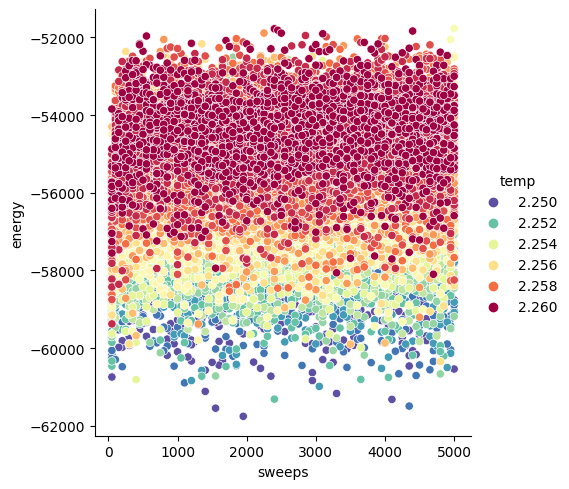

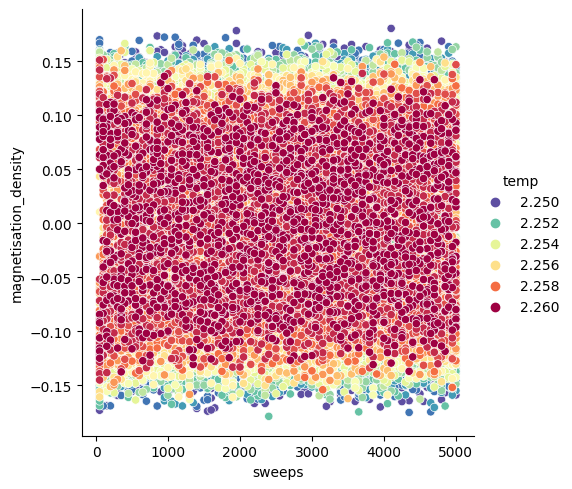

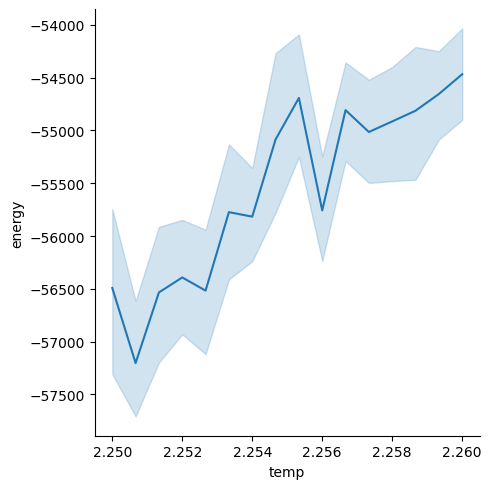

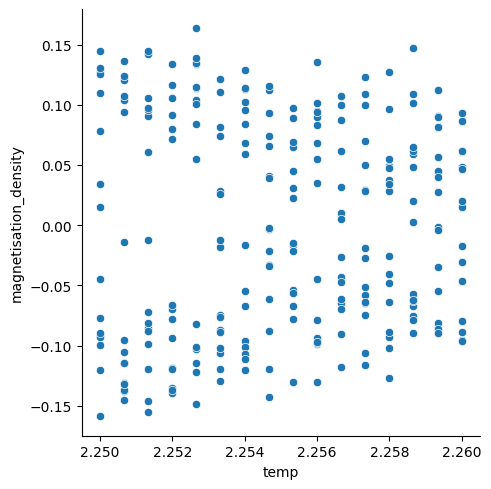

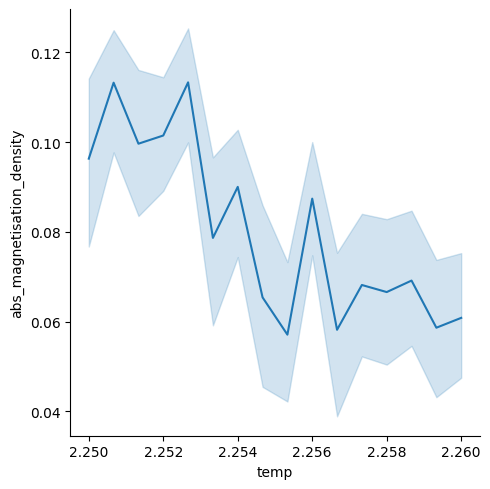

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

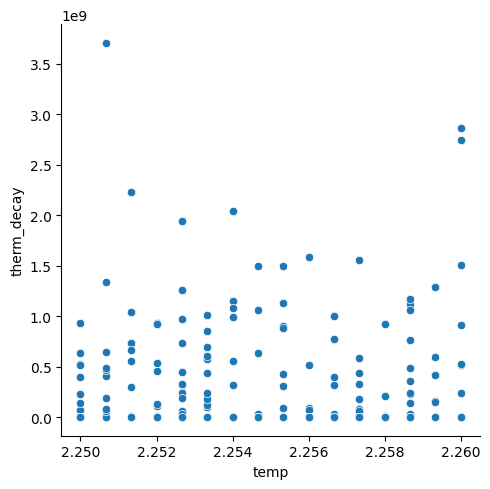

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        250,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                 | 0/8000 [00:00<?, ?it/s]

  0%|▏                                                                                     | 12/8000 [00:13<2:32:39,  1.15s/it]

  0%|▏                                                                                     | 20/8000 [00:14<1:22:43,  1.61it/s]

  0%|▎                                                                                       | 28/8000 [00:14<49:34,  2.68it/s]

  0%|▍                                                                                       | 36/8000 [00:15<34:48,  3.81it/s]

  0%|▍                                                                                       | 40/8000 [00:15<29:04,  4.56it/s]

  1%|▍                                                                                     | 44/8000 [00:27<1:52:45,  1.18it/s]

  1%|▌                                                                                     | 48/8000 [00:28<1:33:57,  1.41it/s]

  1%|▌                                                                                     | 52/8000 [00:28<1:11:14,  1.86it/s]

  1%|▌                                                                                       | 56/8000 [00:28<53:34,  2.47it/s]

  1%|▋                                                                                       | 60/8000 [00:29<44:45,  2.96it/s]

  1%|▋                                                                                       | 64/8000 [00:29<34:49,  3.80it/s]

  1%|▋                                                                                       | 68/8000 [00:29<26:17,  5.03it/s]

  1%|▊                                                                                       | 72/8000 [00:29<19:45,  6.68it/s]

  1%|▊                                                                                     | 76/8000 [00:41<2:05:00,  1.06it/s]

  1%|▊                                                                                     | 80/8000 [00:42<1:38:39,  1.34it/s]

  1%|▉                                                                                     | 88/8000 [00:43<1:00:40,  2.17it/s]

  1%|█                                                                                       | 92/8000 [00:43<49:18,  2.67it/s]

  1%|█                                                                                       | 96/8000 [00:44<42:01,  3.13it/s]

  1%|█                                                                                      | 100/8000 [00:44<31:30,  4.18it/s]

  1%|█▏                                                                                     | 104/8000 [00:44<24:28,  5.38it/s]

  1%|█▏                                                                                   | 108/8000 [00:55<1:58:46,  1.11it/s]

  1%|█▏                                                                                   | 112/8000 [00:56<1:30:58,  1.45it/s]

  1%|█▏                                                                                   | 116/8000 [00:57<1:13:35,  1.79it/s]

  2%|█▎                                                                                     | 120/8000 [00:58<59:59,  2.19it/s]

  2%|█▎                                                                                     | 124/8000 [00:58<45:50,  2.86it/s]

  2%|█▍                                                                                     | 128/8000 [00:58<36:29,  3.60it/s]

  2%|█▍                                                                                     | 132/8000 [00:59<27:49,  4.71it/s]

  2%|█▍                                                                                     | 136/8000 [00:59<22:14,  5.89it/s]

  2%|█▍                                                                                   | 140/8000 [01:09<1:58:57,  1.10it/s]

  2%|█▌                                                                                   | 144/8000 [01:10<1:32:28,  1.42it/s]

  2%|█▌                                                                                   | 148/8000 [01:11<1:12:11,  1.81it/s]

  2%|█▌                                                                                   | 152/8000 [01:12<1:03:15,  2.07it/s]

  2%|█▋                                                                                     | 156/8000 [01:13<49:00,  2.67it/s]

  2%|█▋                                                                                     | 160/8000 [01:13<37:44,  3.46it/s]

  2%|█▊                                                                                     | 164/8000 [01:13<28:21,  4.61it/s]

  2%|█▊                                                                                     | 168/8000 [01:14<23:07,  5.65it/s]

  2%|█▊                                                                                   | 172/8000 [01:24<1:53:39,  1.15it/s]

  2%|█▊                                                                                   | 176/8000 [01:25<1:33:51,  1.39it/s]

  2%|█▉                                                                                   | 180/8000 [01:26<1:13:29,  1.77it/s]

  2%|██                                                                                     | 184/8000 [01:26<54:59,  2.37it/s]

  2%|██                                                                                     | 188/8000 [01:27<44:56,  2.90it/s]

  2%|██                                                                                     | 192/8000 [01:28<43:19,  3.00it/s]

  2%|██▏                                                                                    | 196/8000 [01:29<32:27,  4.01it/s]

  2%|██▏                                                                                    | 200/8000 [01:29<27:29,  4.73it/s]

  3%|██▏                                                                                  | 204/8000 [01:39<1:54:19,  1.14it/s]

  3%|██▏                                                                                  | 208/8000 [01:40<1:34:22,  1.38it/s]

  3%|██▎                                                                                  | 212/8000 [01:41<1:11:08,  1.82it/s]

  3%|██▎                                                                                    | 216/8000 [01:41<51:13,  2.53it/s]

  3%|██▍                                                                                    | 220/8000 [01:41<40:02,  3.24it/s]

  3%|██▍                                                                                    | 224/8000 [01:43<40:00,  3.24it/s]

  3%|██▍                                                                                    | 228/8000 [01:43<30:23,  4.26it/s]

  3%|██▌                                                                                    | 232/8000 [01:43<27:45,  4.66it/s]

  3%|██▌                                                                                  | 236/8000 [01:53<1:47:19,  1.21it/s]

  3%|██▌                                                                                  | 240/8000 [01:55<1:36:46,  1.34it/s]

  3%|██▋                                                                                    | 248/8000 [01:56<57:50,  2.23it/s]

  3%|██▋                                                                                    | 252/8000 [01:56<45:03,  2.87it/s]

  3%|██▊                                                                                    | 256/8000 [01:57<39:56,  3.23it/s]

  3%|██▊                                                                                    | 260/8000 [01:58<41:58,  3.07it/s]

  3%|██▊                                                                                    | 264/8000 [01:58<31:09,  4.14it/s]

  3%|██▊                                                                                  | 268/8000 [02:08<1:52:15,  1.15it/s]

  3%|██▉                                                                                  | 272/8000 [02:09<1:31:56,  1.40it/s]

  3%|██▉                                                                                  | 276/8000 [02:09<1:06:33,  1.93it/s]

  4%|███                                                                                    | 280/8000 [02:10<48:50,  2.63it/s]

  4%|███                                                                                    | 284/8000 [02:10<35:56,  3.58it/s]

  4%|███▏                                                                                   | 288/8000 [02:12<42:36,  3.02it/s]

  4%|███▏                                                                                   | 292/8000 [02:13<41:00,  3.13it/s]

  4%|███▏                                                                                   | 296/8000 [02:13<32:00,  4.01it/s]

  4%|███▏                                                                                 | 300/8000 [02:22<1:49:41,  1.17it/s]

  4%|███▏                                                                                 | 304/8000 [02:23<1:29:28,  1.43it/s]

  4%|███▎                                                                                 | 308/8000 [02:24<1:04:07,  2.00it/s]

  4%|███▍                                                                                   | 320/8000 [02:26<43:12,  2.96it/s]

  4%|███▌                                                                                   | 324/8000 [02:28<44:58,  2.84it/s]

  4%|███▌                                                                                   | 328/8000 [02:28<37:20,  3.42it/s]

  4%|███▌                                                                                 | 332/8000 [02:37<1:37:08,  1.32it/s]

  4%|███▌                                                                                 | 336/8000 [02:38<1:19:43,  1.60it/s]

  4%|███▋                                                                                   | 340/8000 [02:38<59:49,  2.13it/s]

  4%|███▋                                                                                   | 344/8000 [02:38<45:00,  2.83it/s]

  4%|███▊                                                                                   | 348/8000 [02:39<35:40,  3.57it/s]

  4%|███▊                                                                                   | 352/8000 [02:40<42:10,  3.02it/s]

  4%|███▊                                                                                   | 356/8000 [02:42<44:48,  2.84it/s]

  4%|███▉                                                                                   | 360/8000 [02:42<33:53,  3.76it/s]

  5%|███▊                                                                                 | 364/8000 [02:52<1:51:00,  1.15it/s]

  5%|███▉                                                                                 | 372/8000 [02:52<1:01:58,  2.05it/s]

  5%|████                                                                                   | 376/8000 [02:52<47:28,  2.68it/s]

  5%|████▏                                                                                  | 380/8000 [02:53<40:13,  3.16it/s]

  5%|████▏                                                                                  | 384/8000 [02:55<50:49,  2.50it/s]

  5%|████▏                                                                                  | 388/8000 [02:57<50:58,  2.49it/s]

  5%|████▎                                                                                  | 392/8000 [02:57<39:55,  3.18it/s]

  5%|████▏                                                                                | 396/8000 [03:05<1:41:37,  1.25it/s]

  5%|████▎                                                                                | 400/8000 [03:06<1:22:33,  1.53it/s]

  5%|████▍                                                                                  | 404/8000 [03:06<59:38,  2.12it/s]

  5%|████▍                                                                                  | 408/8000 [03:07<44:07,  2.87it/s]

  5%|████▍                                                                                  | 412/8000 [03:07<33:10,  3.81it/s]

  5%|████▌                                                                                  | 416/8000 [03:10<54:34,  2.32it/s]

  5%|████▌                                                                                  | 420/8000 [03:11<48:00,  2.63it/s]

  5%|████▌                                                                                  | 424/8000 [03:12<41:10,  3.07it/s]

  5%|████▌                                                                                | 428/8000 [03:18<1:29:03,  1.42it/s]

  5%|████▌                                                                                | 432/8000 [03:20<1:20:03,  1.58it/s]

  5%|████▋                                                                                  | 436/8000 [03:21<59:40,  2.11it/s]

  6%|████▊                                                                                  | 440/8000 [03:22<50:36,  2.49it/s]

  6%|████▊                                                                                  | 448/8000 [03:25<52:44,  2.39it/s]

  6%|████▉                                                                                  | 452/8000 [03:26<44:47,  2.81it/s]

  6%|████▉                                                                                  | 456/8000 [03:27<41:10,  3.05it/s]

  6%|████▉                                                                                | 460/8000 [03:33<1:22:01,  1.53it/s]

  6%|████▉                                                                                | 464/8000 [03:34<1:12:08,  1.74it/s]

  6%|█████                                                                                  | 468/8000 [03:35<54:39,  2.30it/s]

  6%|█████▏                                                                                 | 472/8000 [03:36<48:49,  2.57it/s]

  6%|█████▏                                                                                 | 480/8000 [03:40<56:50,  2.21it/s]

  6%|█████▎                                                                                 | 484/8000 [03:40<45:04,  2.78it/s]

  6%|█████▎                                                                                 | 488/8000 [03:42<47:44,  2.62it/s]

  6%|█████▏                                                                               | 492/8000 [03:47<1:12:20,  1.73it/s]

  6%|█████▎                                                                               | 496/8000 [03:49<1:10:04,  1.78it/s]

  6%|█████▍                                                                                 | 500/8000 [03:49<53:28,  2.34it/s]

  6%|█████▍                                                                                 | 504/8000 [03:49<39:05,  3.20it/s]

  6%|█████▌                                                                                 | 508/8000 [03:50<35:59,  3.47it/s]

  6%|█████▍                                                                               | 512/8000 [03:54<1:05:24,  1.91it/s]

  6%|█████▌                                                                                 | 516/8000 [03:55<52:42,  2.37it/s]

  6%|█████▋                                                                                 | 520/8000 [03:57<52:40,  2.37it/s]

  7%|█████▌                                                                               | 524/8000 [04:01<1:15:44,  1.65it/s]

  7%|█████▌                                                                               | 528/8000 [04:03<1:10:16,  1.77it/s]

  7%|█████▊                                                                                 | 532/8000 [04:03<50:24,  2.47it/s]

  7%|█████▊                                                                                 | 536/8000 [04:04<46:01,  2.70it/s]

  7%|█████▊                                                                                 | 540/8000 [04:05<39:28,  3.15it/s]

  7%|█████▊                                                                               | 544/8000 [04:08<1:00:15,  2.06it/s]

  7%|█████▉                                                                                 | 548/8000 [04:10<55:02,  2.26it/s]

  7%|█████▊                                                                               | 552/8000 [04:12<1:03:37,  1.95it/s]

  7%|█████▉                                                                               | 556/8000 [04:15<1:09:20,  1.79it/s]

  7%|█████▉                                                                               | 560/8000 [04:17<1:04:34,  1.92it/s]

  7%|██████▏                                                                                | 564/8000 [04:17<50:12,  2.47it/s]

  7%|██████▏                                                                                | 568/8000 [04:18<44:46,  2.77it/s]

  7%|██████▏                                                                                | 572/8000 [04:19<36:11,  3.42it/s]

  7%|██████▎                                                                                | 576/8000 [04:23<59:47,  2.07it/s]

  7%|██████▎                                                                                | 580/8000 [04:24<59:02,  2.09it/s]

  7%|██████▏                                                                              | 584/8000 [04:28<1:11:47,  1.72it/s]

  7%|██████▏                                                                              | 588/8000 [04:29<1:00:06,  2.06it/s]

  7%|██████▎                                                                              | 592/8000 [04:31<1:05:25,  1.89it/s]

  7%|██████▍                                                                                | 596/8000 [04:32<50:48,  2.43it/s]

  8%|██████▌                                                                                | 600/8000 [04:33<48:58,  2.52it/s]

  8%|██████▌                                                                                | 604/8000 [04:34<36:14,  3.40it/s]

  8%|██████▌                                                                                | 608/8000 [04:37<58:06,  2.12it/s]

  8%|██████▌                                                                              | 612/8000 [04:40<1:04:58,  1.89it/s]

  8%|██████▌                                                                              | 616/8000 [04:43<1:16:11,  1.62it/s]

  8%|██████▋                                                                                | 620/8000 [04:43<56:19,  2.18it/s]

  8%|██████▊                                                                                | 624/8000 [04:45<56:35,  2.17it/s]

  8%|██████▊                                                                                | 628/8000 [04:46<43:44,  2.81it/s]

  8%|██████▊                                                                                | 632/8000 [04:47<46:07,  2.66it/s]

  8%|██████▉                                                                                | 636/8000 [04:48<35:23,  3.47it/s]

  8%|██████▉                                                                                | 640/8000 [04:51<59:04,  2.08it/s]

  8%|██████▊                                                                              | 644/8000 [04:55<1:13:37,  1.67it/s]

  8%|██████▉                                                                              | 648/8000 [04:58<1:16:34,  1.60it/s]

  8%|██████▉                                                                              | 652/8000 [04:58<1:00:36,  2.02it/s]

  8%|███████▏                                                                               | 656/8000 [05:00<51:55,  2.36it/s]

  8%|███████▏                                                                               | 660/8000 [05:00<42:55,  2.85it/s]

  8%|███████▏                                                                               | 664/8000 [05:03<51:01,  2.40it/s]

  8%|███████▎                                                                               | 668/8000 [05:03<41:33,  2.94it/s]

  8%|███████▎                                                                               | 672/8000 [05:06<51:37,  2.37it/s]

  8%|███████▏                                                                             | 676/8000 [05:10<1:15:35,  1.61it/s]

  8%|███████▏                                                                             | 680/8000 [05:12<1:11:18,  1.71it/s]

  9%|███████▍                                                                               | 684/8000 [05:13<58:26,  2.09it/s]

  9%|███████▍                                                                               | 688/8000 [05:14<50:16,  2.42it/s]

  9%|███████▌                                                                               | 692/8000 [05:15<41:45,  2.92it/s]

  9%|███████▌                                                                               | 696/8000 [05:17<46:27,  2.62it/s]

  9%|███████▌                                                                               | 700/8000 [05:18<41:33,  2.93it/s]

  9%|███████▋                                                                               | 704/8000 [05:21<57:25,  2.12it/s]

  9%|███████▌                                                                             | 708/8000 [05:24<1:09:53,  1.74it/s]

  9%|███████▌                                                                             | 712/8000 [05:26<1:07:53,  1.79it/s]

  9%|███████▌                                                                             | 716/8000 [05:28<1:02:33,  1.94it/s]

  9%|███████▊                                                                               | 720/8000 [05:28<48:59,  2.48it/s]

  9%|███████▊                                                                               | 724/8000 [05:29<37:08,  3.27it/s]

  9%|███████▉                                                                               | 728/8000 [05:31<47:08,  2.57it/s]

  9%|███████▉                                                                               | 732/8000 [05:32<42:47,  2.83it/s]

  9%|████████                                                                               | 736/8000 [05:35<57:00,  2.12it/s]

  9%|███████▊                                                                             | 740/8000 [05:39<1:13:59,  1.64it/s]

  9%|███████▉                                                                             | 744/8000 [05:40<1:08:07,  1.78it/s]

  9%|███████▉                                                                             | 748/8000 [05:42<1:00:56,  1.98it/s]

  9%|████████▏                                                                              | 752/8000 [05:42<44:11,  2.73it/s]

  9%|████████▏                                                                              | 756/8000 [05:43<35:20,  3.42it/s]

 10%|████████▎                                                                              | 760/8000 [05:45<49:11,  2.45it/s]

 10%|████████▎                                                                              | 764/8000 [05:47<46:22,  2.60it/s]

 10%|████████▎                                                                              | 768/8000 [05:50<59:56,  2.01it/s]

 10%|████████▏                                                                            | 772/8000 [05:53<1:15:06,  1.60it/s]

 10%|████████▏                                                                            | 776/8000 [05:55<1:07:15,  1.79it/s]

 10%|████████▍                                                                              | 780/8000 [05:56<55:22,  2.17it/s]

 10%|████████▌                                                                              | 784/8000 [05:57<44:59,  2.67it/s]

 10%|████████▌                                                                              | 788/8000 [05:57<34:50,  3.45it/s]

 10%|████████▌                                                                              | 792/8000 [06:00<51:25,  2.34it/s]

 10%|████████▋                                                                              | 796/8000 [06:01<45:22,  2.65it/s]

 10%|████████▌                                                                            | 800/8000 [06:04<1:02:37,  1.92it/s]

 10%|████████▌                                                                            | 804/8000 [06:08<1:18:00,  1.54it/s]

 10%|████████▌                                                                            | 808/8000 [06:09<1:04:20,  1.86it/s]

 10%|████████▊                                                                              | 812/8000 [06:10<46:52,  2.56it/s]

 10%|████████▊                                                                              | 816/8000 [06:11<48:44,  2.46it/s]

 10%|████████▉                                                                              | 820/8000 [06:12<43:02,  2.78it/s]

 10%|████████▉                                                                              | 824/8000 [06:14<48:58,  2.44it/s]

 10%|█████████                                                                              | 828/8000 [06:15<37:19,  3.20it/s]

 10%|████████▊                                                                            | 832/8000 [06:19<1:00:22,  1.98it/s]

 10%|████████▉                                                                            | 836/8000 [06:23<1:20:58,  1.47it/s]

 10%|████████▉                                                                            | 840/8000 [06:23<1:00:05,  1.99it/s]

 11%|█████████▏                                                                             | 844/8000 [06:23<43:55,  2.71it/s]

 11%|█████████▏                                                                             | 848/8000 [06:26<49:12,  2.42it/s]

 11%|█████████▎                                                                             | 852/8000 [06:27<45:44,  2.60it/s]

 11%|█████████▎                                                                             | 856/8000 [06:28<39:58,  2.98it/s]

 11%|█████████▎                                                                             | 860/8000 [06:30<44:14,  2.69it/s]

 11%|█████████▏                                                                           | 864/8000 [06:33<1:00:26,  1.97it/s]

 11%|█████████▏                                                                           | 868/8000 [06:37<1:17:42,  1.53it/s]

 11%|█████████▎                                                                           | 872/8000 [06:38<1:04:34,  1.84it/s]

 11%|█████████▌                                                                             | 876/8000 [06:38<48:32,  2.45it/s]

 11%|█████████▌                                                                             | 880/8000 [06:40<46:48,  2.54it/s]

 11%|█████████▌                                                                             | 884/8000 [06:42<55:47,  2.13it/s]

 11%|█████████▋                                                                             | 888/8000 [06:43<40:33,  2.92it/s]

 11%|█████████▋                                                                             | 892/8000 [06:44<42:24,  2.79it/s]

 11%|█████████▋                                                                             | 896/8000 [06:47<54:41,  2.16it/s]

 11%|█████████▌                                                                           | 900/8000 [06:51<1:10:11,  1.69it/s]

 11%|█████████▊                                                                             | 904/8000 [06:52<59:31,  1.99it/s]

 11%|█████████▊                                                                             | 908/8000 [06:53<49:43,  2.38it/s]

 11%|█████████▉                                                                             | 912/8000 [06:54<44:12,  2.67it/s]

 11%|█████████▋                                                                           | 916/8000 [06:58<1:06:20,  1.78it/s]

 12%|██████████                                                                             | 924/8000 [06:59<46:01,  2.56it/s]

 12%|██████████                                                                             | 928/8000 [07:02<54:15,  2.17it/s]

 12%|█████████▉                                                                           | 932/8000 [07:05<1:00:24,  1.95it/s]

 12%|██████████▏                                                                            | 936/8000 [07:06<53:29,  2.20it/s]

 12%|██████████▏                                                                            | 940/8000 [07:08<53:14,  2.21it/s]

 12%|██████████▎                                                                            | 944/8000 [07:08<41:06,  2.86it/s]

 12%|██████████                                                                           | 948/8000 [07:12<1:04:23,  1.83it/s]

 12%|██████████▎                                                                            | 952/8000 [07:12<49:11,  2.39it/s]

 12%|██████████▍                                                                            | 956/8000 [07:14<46:15,  2.54it/s]

 12%|██████████▍                                                                            | 960/8000 [07:16<54:34,  2.15it/s]

 12%|██████████▍                                                                            | 964/8000 [07:18<53:53,  2.18it/s]

 12%|██████████▌                                                                            | 968/8000 [07:19<47:21,  2.48it/s]

 12%|██████████▌                                                                            | 972/8000 [07:22<57:19,  2.04it/s]

 12%|██████████▌                                                                            | 976/8000 [07:23<46:59,  2.49it/s]

 12%|██████████▍                                                                          | 980/8000 [07:27<1:09:34,  1.68it/s]

 12%|██████████▋                                                                            | 984/8000 [07:27<53:24,  2.19it/s]

 12%|██████████▋                                                                            | 988/8000 [07:28<42:29,  2.75it/s]

 12%|██████████▊                                                                            | 992/8000 [07:31<51:37,  2.26it/s]

 12%|██████████▊                                                                            | 996/8000 [07:32<44:47,  2.61it/s]

 12%|██████████▊                                                                           | 1000/8000 [07:33<45:49,  2.55it/s]

 13%|██████████▌                                                                         | 1004/8000 [07:37<1:02:19,  1.87it/s]

 13%|██████████▊                                                                           | 1008/8000 [07:38<54:25,  2.14it/s]

 13%|██████████▋                                                                         | 1012/8000 [07:41<1:06:38,  1.75it/s]

 13%|██████████▉                                                                           | 1016/8000 [07:42<57:42,  2.02it/s]

 13%|██████████▉                                                                           | 1020/8000 [07:43<41:37,  2.79it/s]

 13%|███████████                                                                           | 1024/8000 [07:45<52:51,  2.20it/s]

 13%|███████████                                                                           | 1028/8000 [07:46<42:55,  2.71it/s]

 13%|███████████                                                                           | 1032/8000 [07:47<39:25,  2.95it/s]

 13%|███████████▏                                                                          | 1036/8000 [07:51<59:46,  1.94it/s]

 13%|██████████▉                                                                         | 1040/8000 [07:53<1:02:22,  1.86it/s]

 13%|██████████▉                                                                         | 1044/8000 [07:56<1:04:31,  1.80it/s]

 13%|███████████▎                                                                          | 1048/8000 [07:57<55:43,  2.08it/s]

 13%|███████████▎                                                                          | 1056/8000 [08:00<49:54,  2.32it/s]

 13%|███████████▍                                                                          | 1060/8000 [08:00<42:11,  2.74it/s]

 13%|███████████▍                                                                          | 1064/8000 [08:01<36:57,  3.13it/s]

 13%|███████████▍                                                                          | 1068/8000 [08:05<59:15,  1.95it/s]

 13%|███████████▌                                                                          | 1072/8000 [08:07<59:42,  1.93it/s]

 13%|███████████▎                                                                        | 1076/8000 [08:10<1:01:09,  1.89it/s]

 14%|███████████▌                                                                          | 1080/8000 [08:11<55:38,  2.07it/s]

 14%|███████████▋                                                                          | 1084/8000 [08:12<48:34,  2.37it/s]

 14%|███████████▋                                                                          | 1088/8000 [08:13<43:31,  2.65it/s]

 14%|███████████▋                                                                          | 1092/8000 [08:15<40:51,  2.82it/s]

 14%|███████████▊                                                                          | 1096/8000 [08:15<36:28,  3.15it/s]

 14%|███████████▌                                                                        | 1100/8000 [08:20<1:01:57,  1.86it/s]

 14%|███████████▌                                                                        | 1104/8000 [08:22<1:06:40,  1.72it/s]

 14%|███████████▋                                                                        | 1108/8000 [08:24<1:03:09,  1.82it/s]

 14%|███████████▉                                                                          | 1112/8000 [08:26<55:33,  2.07it/s]

 14%|███████████▉                                                                          | 1116/8000 [08:27<50:10,  2.29it/s]

 14%|████████████                                                                          | 1120/8000 [08:28<44:04,  2.60it/s]

 14%|████████████                                                                          | 1124/8000 [08:29<39:35,  2.89it/s]

 14%|████████████▏                                                                         | 1128/8000 [08:30<32:36,  3.51it/s]

 14%|███████████▉                                                                        | 1132/8000 [08:35<1:09:05,  1.66it/s]

 14%|███████████▉                                                                        | 1136/8000 [08:37<1:07:04,  1.71it/s]

 14%|███████████▉                                                                        | 1140/8000 [08:39<1:05:47,  1.74it/s]

 14%|████████████▎                                                                         | 1144/8000 [08:41<57:32,  1.99it/s]

 14%|████████████▎                                                                         | 1148/8000 [08:42<48:01,  2.38it/s]

 14%|████████████▍                                                                         | 1152/8000 [08:42<34:58,  3.26it/s]

 14%|████████████▍                                                                         | 1156/8000 [08:43<31:56,  3.57it/s]

 14%|████████████▍                                                                         | 1160/8000 [08:44<31:59,  3.56it/s]

 15%|████████████▏                                                                       | 1164/8000 [08:49<1:08:16,  1.67it/s]

 15%|████████████▎                                                                       | 1168/8000 [08:51<1:05:28,  1.74it/s]

 15%|████████████▎                                                                       | 1172/8000 [08:55<1:14:49,  1.52it/s]

 15%|████████████▋                                                                         | 1176/8000 [08:55<59:41,  1.91it/s]

 15%|████████████▋                                                                         | 1180/8000 [08:56<43:05,  2.64it/s]

 15%|████████████▋                                                                         | 1184/8000 [08:56<33:36,  3.38it/s]

 15%|████████████▊                                                                         | 1188/8000 [08:57<30:09,  3.76it/s]

 15%|████████████▊                                                                         | 1192/8000 [08:59<36:43,  3.09it/s]

 15%|████████████▌                                                                       | 1196/8000 [09:04<1:10:55,  1.60it/s]

 15%|████████████▌                                                                       | 1200/8000 [09:07<1:14:07,  1.53it/s]

 15%|████████████▋                                                                       | 1204/8000 [09:08<1:02:26,  1.81it/s]

 15%|████████████▋                                                                       | 1208/8000 [09:11<1:06:55,  1.69it/s]

 15%|█████████████                                                                         | 1216/8000 [09:11<38:03,  2.97it/s]

 15%|█████████████                                                                         | 1220/8000 [09:11<30:55,  3.65it/s]

 15%|█████████████▏                                                                        | 1224/8000 [09:13<32:26,  3.48it/s]

 15%|████████████▉                                                                       | 1228/8000 [09:18<1:03:16,  1.78it/s]

 15%|████████████▉                                                                       | 1232/8000 [09:21<1:12:10,  1.56it/s]

 15%|████████████▉                                                                       | 1236/8000 [09:23<1:01:33,  1.83it/s]

 16%|█████████████                                                                       | 1240/8000 [09:25<1:02:08,  1.81it/s]

 16%|█████████████▎                                                                        | 1244/8000 [09:25<47:19,  2.38it/s]

 16%|█████████████▍                                                                        | 1248/8000 [09:25<34:54,  3.22it/s]

 16%|█████████████▍                                                                        | 1252/8000 [09:26<27:26,  4.10it/s]

 16%|█████████████▌                                                                        | 1256/8000 [09:28<34:04,  3.30it/s]

 16%|█████████████▏                                                                      | 1260/8000 [09:32<1:04:06,  1.75it/s]

 16%|█████████████▎                                                                      | 1264/8000 [09:36<1:16:03,  1.48it/s]

 16%|█████████████▎                                                                      | 1268/8000 [09:37<1:01:20,  1.83it/s]

 16%|█████████████▋                                                                        | 1272/8000 [09:39<57:19,  1.96it/s]

 16%|█████████████▋                                                                        | 1276/8000 [09:39<44:18,  2.53it/s]

 16%|█████████████▊                                                                        | 1280/8000 [09:40<36:01,  3.11it/s]

 16%|█████████████▊                                                                        | 1284/8000 [09:40<27:33,  4.06it/s]

 16%|█████████████▊                                                                        | 1288/8000 [09:42<37:50,  2.96it/s]

 16%|█████████████▌                                                                      | 1292/8000 [09:47<1:04:32,  1.73it/s]

 16%|█████████████▌                                                                      | 1296/8000 [09:50<1:14:19,  1.50it/s]

 16%|█████████████▉                                                                        | 1300/8000 [09:51<56:16,  1.98it/s]

 16%|█████████████▋                                                                      | 1304/8000 [09:54<1:03:43,  1.75it/s]

 16%|██████████████                                                                        | 1312/8000 [09:55<40:29,  2.75it/s]

 16%|██████████████▏                                                                       | 1316/8000 [09:56<37:59,  2.93it/s]

 16%|██████████████▏                                                                       | 1320/8000 [09:57<35:53,  3.10it/s]

 17%|█████████████▉                                                                      | 1324/8000 [10:02<1:02:34,  1.78it/s]

 17%|█████████████▉                                                                      | 1328/8000 [10:05<1:14:00,  1.50it/s]

 17%|██████████████▎                                                                       | 1332/8000 [10:06<54:07,  2.05it/s]

 17%|██████████████▎                                                                       | 1336/8000 [10:07<52:18,  2.12it/s]

 17%|██████████████▍                                                                       | 1340/8000 [10:08<43:10,  2.57it/s]

 17%|██████████████▍                                                                       | 1344/8000 [10:10<42:09,  2.63it/s]

 17%|██████████████▍                                                                       | 1348/8000 [10:11<38:42,  2.86it/s]

 17%|██████████████▌                                                                       | 1352/8000 [10:11<29:36,  3.74it/s]

 17%|██████████████▏                                                                     | 1356/8000 [10:17<1:08:49,  1.61it/s]

 17%|██████████████▎                                                                     | 1360/8000 [10:21<1:20:22,  1.38it/s]

 17%|██████████████▋                                                                       | 1364/8000 [10:21<57:09,  1.94it/s]

 17%|██████████████▋                                                                       | 1368/8000 [10:21<41:49,  2.64it/s]

 17%|██████████████▋                                                                       | 1372/8000 [10:22<40:32,  2.72it/s]

 17%|██████████████▊                                                                       | 1376/8000 [10:25<47:14,  2.34it/s]

 17%|██████████████▊                                                                       | 1380/8000 [10:25<37:34,  2.94it/s]

 17%|██████████████▉                                                                       | 1384/8000 [10:26<30:58,  3.56it/s]

 17%|██████████████▌                                                                     | 1388/8000 [10:31<1:04:28,  1.71it/s]

 17%|██████████████▌                                                                     | 1392/8000 [10:35<1:19:01,  1.39it/s]

 18%|███████████████                                                                       | 1400/8000 [10:36<46:22,  2.37it/s]

 18%|███████████████                                                                       | 1404/8000 [10:37<41:12,  2.67it/s]

 18%|███████████████▏                                                                      | 1408/8000 [10:39<48:27,  2.27it/s]

 18%|███████████████▏                                                                      | 1412/8000 [10:40<43:30,  2.52it/s]

 18%|███████████████▏                                                                      | 1416/8000 [10:41<35:37,  3.08it/s]

 18%|███████████████▎                                                                      | 1420/8000 [10:45<58:35,  1.87it/s]

 18%|██████████████▉                                                                     | 1424/8000 [10:49<1:10:24,  1.56it/s]

 18%|███████████████▎                                                                      | 1428/8000 [10:49<51:34,  2.12it/s]

 18%|███████████████▍                                                                      | 1432/8000 [10:51<51:10,  2.14it/s]

 18%|███████████████▍                                                                      | 1436/8000 [10:51<39:43,  2.75it/s]

 18%|███████████████▍                                                                      | 1440/8000 [10:54<53:17,  2.05it/s]

 18%|███████████████▌                                                                      | 1448/8000 [10:55<36:46,  2.97it/s]

 18%|███████████████▌                                                                      | 1452/8000 [11:00<55:22,  1.97it/s]

 18%|███████████████▋                                                                      | 1456/8000 [11:02<58:18,  1.87it/s]

 18%|███████████████▋                                                                      | 1460/8000 [11:03<46:34,  2.34it/s]

 18%|███████████████▋                                                                      | 1464/8000 [11:04<47:35,  2.29it/s]

 18%|███████████████▊                                                                      | 1468/8000 [11:05<41:58,  2.59it/s]

 18%|███████████████▊                                                                      | 1472/8000 [11:09<56:35,  1.92it/s]

 18%|███████████████▊                                                                      | 1476/8000 [11:09<44:34,  2.44it/s]

 18%|███████████████▉                                                                      | 1480/8000 [11:10<33:14,  3.27it/s]

 19%|███████████████▉                                                                      | 1484/8000 [11:14<56:23,  1.93it/s]

 19%|███████████████▉                                                                      | 1488/8000 [11:16<54:47,  1.98it/s]

 19%|████████████████                                                                      | 1492/8000 [11:18<57:04,  1.90it/s]

 19%|████████████████                                                                      | 1496/8000 [11:19<48:05,  2.25it/s]

 19%|████████████████▏                                                                     | 1500/8000 [11:20<42:19,  2.56it/s]

 19%|████████████████▏                                                                     | 1504/8000 [11:24<58:36,  1.85it/s]

 19%|████████████████▎                                                                     | 1512/8000 [11:24<34:04,  3.17it/s]

 19%|████████████████▎                                                                     | 1516/8000 [11:28<51:51,  2.08it/s]

 19%|████████████████▎                                                                     | 1520/8000 [11:29<48:59,  2.20it/s]

 19%|████████████████▍                                                                     | 1524/8000 [11:32<55:15,  1.95it/s]

 19%|████████████████▍                                                                     | 1528/8000 [11:33<46:00,  2.34it/s]

 19%|████████████████▍                                                                     | 1532/8000 [11:34<44:14,  2.44it/s]

 19%|████████████████▏                                                                   | 1536/8000 [11:38<1:02:01,  1.74it/s]

 19%|████████████████▌                                                                     | 1544/8000 [11:39<36:44,  2.93it/s]

 19%|████████████████▋                                                                     | 1548/8000 [11:43<53:42,  2.00it/s]

 19%|████████████████▋                                                                     | 1552/8000 [11:44<46:03,  2.33it/s]

 19%|████████████████▋                                                                     | 1556/8000 [11:47<55:17,  1.94it/s]

 20%|████████████████▊                                                                     | 1560/8000 [11:47<41:51,  2.56it/s]

 20%|████████████████▊                                                                     | 1564/8000 [11:49<49:02,  2.19it/s]

 20%|████████████████▊                                                                     | 1568/8000 [11:52<53:49,  1.99it/s]

 20%|████████████████▉                                                                     | 1572/8000 [11:53<49:54,  2.15it/s]

 20%|████████████████▉                                                                     | 1580/8000 [11:57<48:18,  2.21it/s]

 20%|█████████████████                                                                     | 1584/8000 [11:57<39:51,  2.68it/s]

 20%|█████████████████                                                                     | 1588/8000 [12:01<54:24,  1.96it/s]

 20%|█████████████████                                                                     | 1592/8000 [12:02<47:17,  2.26it/s]

 20%|█████████████████▏                                                                    | 1596/8000 [12:04<47:10,  2.26it/s]

 20%|█████████████████▏                                                                    | 1600/8000 [12:07<56:09,  1.90it/s]

 20%|█████████████████▏                                                                    | 1604/8000 [12:08<51:05,  2.09it/s]

 20%|█████████████████▎                                                                    | 1612/8000 [12:11<45:55,  2.32it/s]

 20%|█████████████████▎                                                                    | 1616/8000 [12:12<41:26,  2.57it/s]

 20%|█████████████████▍                                                                    | 1620/8000 [12:15<51:16,  2.07it/s]

 20%|█████████████████▍                                                                    | 1624/8000 [12:17<50:19,  2.11it/s]

 20%|█████████████████▌                                                                    | 1628/8000 [12:18<42:49,  2.48it/s]

 20%|█████████████████▏                                                                  | 1632/8000 [12:22<1:01:55,  1.71it/s]

 20%|█████████████████▌                                                                    | 1636/8000 [12:23<50:22,  2.11it/s]

 20%|█████████████████▋                                                                    | 1640/8000 [12:23<37:47,  2.80it/s]

 21%|█████████████████▋                                                                    | 1644/8000 [12:25<40:00,  2.65it/s]

 21%|█████████████████▋                                                                    | 1648/8000 [12:26<35:27,  2.99it/s]

 21%|█████████████████▊                                                                    | 1652/8000 [12:30<55:18,  1.91it/s]

 21%|█████████████████▊                                                                    | 1656/8000 [12:32<54:08,  1.95it/s]

 21%|█████████████████▊                                                                    | 1660/8000 [12:32<43:47,  2.41it/s]

 21%|█████████████████▍                                                                  | 1664/8000 [12:37<1:03:44,  1.66it/s]

 21%|█████████████████▉                                                                    | 1668/8000 [12:38<53:38,  1.97it/s]

 21%|█████████████████▉                                                                    | 1672/8000 [12:38<40:00,  2.64it/s]

 21%|██████████████████                                                                    | 1676/8000 [12:39<36:13,  2.91it/s]

 21%|██████████████████                                                                    | 1680/8000 [12:41<40:03,  2.63it/s]

 21%|██████████████████                                                                    | 1684/8000 [12:43<46:10,  2.28it/s]

 21%|██████████████████▏                                                                   | 1688/8000 [12:46<55:25,  1.90it/s]

 21%|██████████████████▏                                                                   | 1692/8000 [12:48<53:50,  1.95it/s]

 21%|█████████████████▊                                                                  | 1696/8000 [12:51<1:03:46,  1.65it/s]

 21%|██████████████████▎                                                                   | 1700/8000 [12:52<51:04,  2.06it/s]

 21%|██████████████████▎                                                                   | 1704/8000 [12:53<39:52,  2.63it/s]

 21%|██████████████████▎                                                                   | 1708/8000 [12:53<30:24,  3.45it/s]

 21%|██████████████████▍                                                                   | 1712/8000 [12:55<37:12,  2.82it/s]

 21%|██████████████████▍                                                                   | 1716/8000 [12:57<42:34,  2.46it/s]

 22%|██████████████████▍                                                                   | 1720/8000 [13:00<51:53,  2.02it/s]

 22%|██████████████████▌                                                                   | 1724/8000 [13:03<59:36,  1.75it/s]

 22%|██████████████████▏                                                                 | 1728/8000 [13:06<1:05:17,  1.60it/s]

 22%|██████████████████▌                                                                   | 1732/8000 [13:07<50:18,  2.08it/s]

 22%|██████████████████▋                                                                   | 1736/8000 [13:07<39:37,  2.63it/s]

 22%|██████████████████▋                                                                   | 1744/8000 [13:09<33:06,  3.15it/s]

 22%|██████████████████▊                                                                   | 1748/8000 [13:11<39:59,  2.61it/s]

 22%|██████████████████▊                                                                   | 1752/8000 [13:14<50:01,  2.08it/s]

 22%|██████████████████▍                                                                 | 1756/8000 [13:18<1:00:18,  1.73it/s]

 22%|██████████████████▍                                                                 | 1760/8000 [13:20<1:02:00,  1.68it/s]

 22%|██████████████████▉                                                                   | 1764/8000 [13:21<48:03,  2.16it/s]

 22%|███████████████████                                                                   | 1768/8000 [13:22<42:11,  2.46it/s]

 22%|███████████████████                                                                   | 1776/8000 [13:23<31:20,  3.31it/s]

 22%|███████████████████▏                                                                  | 1780/8000 [13:25<35:27,  2.92it/s]

 22%|███████████████████▏                                                                  | 1784/8000 [13:29<49:10,  2.11it/s]

 22%|██████████████████▊                                                                 | 1788/8000 [13:33<1:05:20,  1.58it/s]

 22%|██████████████████▊                                                                 | 1792/8000 [13:35<1:01:44,  1.68it/s]

 22%|███████████████████▎                                                                  | 1796/8000 [13:35<45:22,  2.28it/s]

 22%|███████████████████▎                                                                  | 1800/8000 [13:36<35:58,  2.87it/s]

 23%|███████████████████▍                                                                  | 1804/8000 [13:37<35:08,  2.94it/s]

 23%|███████████████████▍                                                                  | 1808/8000 [13:38<35:25,  2.91it/s]

 23%|███████████████████▍                                                                  | 1812/8000 [13:39<32:58,  3.13it/s]

 23%|███████████████████▌                                                                  | 1816/8000 [13:43<52:07,  1.98it/s]

 23%|███████████████████                                                                 | 1820/8000 [13:47<1:09:14,  1.49it/s]

 23%|███████████████████▏                                                                | 1824/8000 [13:49<1:02:07,  1.66it/s]

 23%|███████████████████▋                                                                  | 1828/8000 [13:49<45:55,  2.24it/s]

 23%|███████████████████▋                                                                  | 1832/8000 [13:50<33:49,  3.04it/s]

 23%|███████████████████▋                                                                  | 1836/8000 [13:52<38:20,  2.68it/s]

 23%|███████████████████▊                                                                  | 1840/8000 [13:53<36:51,  2.79it/s]

 23%|███████████████████▊                                                                  | 1844/8000 [13:54<32:03,  3.20it/s]

 23%|███████████████████▊                                                                  | 1848/8000 [13:57<49:55,  2.05it/s]

 23%|███████████████████▍                                                                | 1852/8000 [14:02<1:12:31,  1.41it/s]

 23%|███████████████████▉                                                                  | 1856/8000 [14:03<57:42,  1.77it/s]

 23%|████████████████████                                                                  | 1864/8000 [14:04<35:10,  2.91it/s]

 23%|████████████████████                                                                  | 1868/8000 [14:07<47:21,  2.16it/s]

 23%|████████████████████                                                                  | 1872/8000 [14:07<35:39,  2.86it/s]

 23%|████████████████████▏                                                                 | 1876/8000 [14:08<32:02,  3.19it/s]

 24%|████████████████████▏                                                                 | 1880/8000 [14:12<49:15,  2.07it/s]

 24%|███████████████████▊                                                                | 1884/8000 [14:17<1:14:53,  1.36it/s]

 24%|████████████████████▎                                                                 | 1892/8000 [14:18<43:37,  2.33it/s]

 24%|████████████████████▍                                                                 | 1896/8000 [14:18<35:10,  2.89it/s]

 24%|████████████████████▍                                                                 | 1900/8000 [14:22<49:25,  2.06it/s]

 24%|████████████████████▌                                                                 | 1908/8000 [14:22<31:13,  3.25it/s]

 24%|████████████████████▌                                                                 | 1912/8000 [14:26<44:35,  2.28it/s]

 24%|████████████████████                                                                | 1916/8000 [14:31<1:08:49,  1.47it/s]

 24%|████████████████████▋                                                                 | 1920/8000 [14:32<55:01,  1.84it/s]

 24%|████████████████████▋                                                                 | 1924/8000 [14:32<41:43,  2.43it/s]

 24%|████████████████████▋                                                                 | 1928/8000 [14:32<33:10,  3.05it/s]

 24%|████████████████████▊                                                                 | 1932/8000 [14:36<47:00,  2.15it/s]

 24%|████████████████████▊                                                                 | 1936/8000 [14:36<37:50,  2.67it/s]

 24%|████████████████████▉                                                                 | 1944/8000 [14:40<42:22,  2.38it/s]

 24%|████████████████████▍                                                               | 1948/8000 [14:45<1:03:50,  1.58it/s]

 24%|████████████████████▉                                                                 | 1952/8000 [14:46<53:00,  1.90it/s]

 24%|█████████████████████                                                                 | 1956/8000 [14:47<41:17,  2.44it/s]

 24%|█████████████████████                                                                 | 1960/8000 [14:47<34:36,  2.91it/s]

 25%|█████████████████████                                                                 | 1964/8000 [14:50<46:43,  2.15it/s]

 25%|█████████████████████▏                                                                | 1968/8000 [14:51<39:32,  2.54it/s]

 25%|█████████████████████▏                                                                | 1972/8000 [14:52<31:16,  3.21it/s]

 25%|█████████████████████▏                                                                | 1976/8000 [14:55<44:05,  2.28it/s]

 25%|████████████████████▊                                                               | 1980/8000 [14:59<1:04:25,  1.56it/s]

 25%|█████████████████████▎                                                                | 1984/8000 [15:01<56:19,  1.78it/s]

 25%|█████████████████████▎                                                                | 1988/8000 [15:01<45:22,  2.21it/s]

 25%|█████████████████████▍                                                                | 1992/8000 [15:02<38:58,  2.57it/s]

 25%|█████████████████████▍                                                                | 1996/8000 [15:05<45:22,  2.21it/s]

 25%|█████████████████████▌                                                                | 2000/8000 [15:06<39:16,  2.55it/s]

 25%|█████████████████████▌                                                                | 2004/8000 [15:07<37:20,  2.68it/s]

 25%|█████████████████████▌                                                                | 2008/8000 [15:08<35:32,  2.81it/s]

 25%|█████████████████████▏                                                              | 2012/8000 [15:14<1:07:05,  1.49it/s]

 25%|█████████████████████▋                                                                | 2016/8000 [15:15<56:48,  1.76it/s]

 25%|█████████████████████▋                                                                | 2020/8000 [15:16<46:09,  2.16it/s]

 25%|█████████████████████▊                                                                | 2028/8000 [15:19<41:46,  2.38it/s]

 25%|█████████████████████▊                                                                | 2032/8000 [15:21<41:20,  2.41it/s]

 25%|█████████████████████▉                                                                | 2036/8000 [15:22<38:10,  2.60it/s]

 26%|█████████████████████▉                                                                | 2040/8000 [15:23<33:05,  3.00it/s]

 26%|█████████████████████▍                                                              | 2044/8000 [15:29<1:05:51,  1.51it/s]

 26%|██████████████████████                                                                | 2048/8000 [15:30<55:41,  1.78it/s]

 26%|██████████████████████                                                                | 2052/8000 [15:31<47:09,  2.10it/s]

 26%|██████████████████████                                                                | 2056/8000 [15:32<38:03,  2.60it/s]

 26%|██████████████████████▏                                                               | 2060/8000 [15:33<37:48,  2.62it/s]

 26%|██████████████████████▏                                                               | 2064/8000 [15:35<37:47,  2.62it/s]

 26%|██████████████████████▏                                                               | 2068/8000 [15:37<40:36,  2.43it/s]

 26%|██████████████████████▎                                                               | 2072/8000 [15:38<37:02,  2.67it/s]

 26%|█████████████████████▊                                                              | 2076/8000 [15:44<1:10:07,  1.41it/s]

 26%|██████████████████████▎                                                               | 2080/8000 [15:45<55:47,  1.77it/s]

 26%|██████████████████████▍                                                               | 2084/8000 [15:46<49:03,  2.01it/s]

 26%|██████████████████████▍                                                               | 2088/8000 [15:46<36:39,  2.69it/s]

 26%|██████████████████████▍                                                               | 2092/8000 [15:48<41:21,  2.38it/s]

 26%|██████████████████████▌                                                               | 2096/8000 [15:49<29:47,  3.30it/s]

 26%|██████████████████████▌                                                               | 2100/8000 [15:51<38:37,  2.55it/s]

 26%|██████████████████████▌                                                               | 2104/8000 [15:53<40:03,  2.45it/s]

 26%|██████████████████████▏                                                             | 2108/8000 [15:58<1:02:45,  1.56it/s]

 26%|██████████████████████▋                                                               | 2112/8000 [15:59<57:15,  1.71it/s]

 26%|██████████████████████▋                                                               | 2116/8000 [16:01<53:38,  1.83it/s]

 26%|██████████████████████▊                                                               | 2120/8000 [16:01<39:29,  2.48it/s]

 27%|██████████████████████▊                                                               | 2124/8000 [16:03<41:58,  2.33it/s]

 27%|██████████████████████▉                                                               | 2132/8000 [16:05<34:22,  2.84it/s]

 27%|██████████████████████▉                                                               | 2136/8000 [16:08<39:31,  2.47it/s]

 27%|███████████████████████                                                               | 2140/8000 [16:10<46:42,  2.09it/s]

 27%|███████████████████████                                                               | 2144/8000 [16:14<56:07,  1.74it/s]

 27%|███████████████████████                                                               | 2148/8000 [16:16<53:32,  1.82it/s]

 27%|███████████████████████▏                                                              | 2152/8000 [16:16<39:25,  2.47it/s]

 27%|███████████████████████▏                                                              | 2156/8000 [16:18<41:18,  2.36it/s]

 27%|███████████████████████▏                                                              | 2160/8000 [16:18<33:56,  2.87it/s]

 27%|███████████████████████▎                                                              | 2164/8000 [16:20<33:24,  2.91it/s]

 27%|███████████████████████▎                                                              | 2168/8000 [16:23<44:00,  2.21it/s]

 27%|███████████████████████▎                                                              | 2172/8000 [16:26<52:58,  1.83it/s]

 27%|███████████████████████▍                                                              | 2176/8000 [16:29<58:50,  1.65it/s]

 27%|███████████████████████▍                                                              | 2180/8000 [16:31<55:34,  1.75it/s]

 27%|███████████████████████▍                                                              | 2184/8000 [16:31<41:32,  2.33it/s]

 27%|███████████████████████▌                                                              | 2188/8000 [16:32<38:54,  2.49it/s]

 27%|███████████████████████▌                                                              | 2192/8000 [16:33<28:52,  3.35it/s]

 27%|███████████████████████▌                                                              | 2196/8000 [16:34<30:46,  3.14it/s]

 28%|███████████████████████▋                                                              | 2200/8000 [16:38<49:04,  1.97it/s]

 28%|███████████████████████▋                                                              | 2204/8000 [16:40<46:16,  2.09it/s]

 28%|███████████████████████▏                                                            | 2208/8000 [16:43<1:00:11,  1.60it/s]

 28%|███████████████████████▊                                                              | 2212/8000 [16:45<55:26,  1.74it/s]

 28%|███████████████████████▊                                                              | 2216/8000 [16:46<47:10,  2.04it/s]

 28%|███████████████████████▊                                                              | 2220/8000 [16:47<34:09,  2.82it/s]

 28%|███████████████████████▉                                                              | 2224/8000 [16:47<27:48,  3.46it/s]

 28%|███████████████████████▉                                                              | 2228/8000 [16:48<26:55,  3.57it/s]

 28%|███████████████████████▉                                                              | 2232/8000 [16:53<51:14,  1.88it/s]

 28%|████████████████████████                                                              | 2236/8000 [16:54<44:28,  2.16it/s]

 28%|███████████████████████▌                                                            | 2240/8000 [16:58<1:02:02,  1.55it/s]

 28%|████████████████████████                                                              | 2244/8000 [16:59<51:55,  1.85it/s]

 28%|████████████████████████▏                                                             | 2248/8000 [17:00<43:07,  2.22it/s]

 28%|████████████████████████▏                                                             | 2252/8000 [17:01<35:52,  2.67it/s]

 28%|████████████████████████▎                                                             | 2260/8000 [17:02<24:02,  3.98it/s]

 28%|████████████████████████▎                                                             | 2264/8000 [17:08<52:33,  1.82it/s]

 28%|████████████████████████▍                                                             | 2268/8000 [17:08<40:59,  2.33it/s]

 28%|███████████████████████▊                                                            | 2272/8000 [17:13<1:03:30,  1.50it/s]

 28%|████████████████████████▍                                                             | 2276/8000 [17:14<52:37,  1.81it/s]

 29%|████████████████████████▌                                                             | 2284/8000 [17:15<34:06,  2.79it/s]

 29%|████████████████████████▌                                                             | 2288/8000 [17:15<27:24,  3.47it/s]

 29%|████████████████████████▋                                                             | 2292/8000 [17:16<24:40,  3.85it/s]

 29%|████████████████████████▋                                                             | 2296/8000 [17:22<52:10,  1.82it/s]

 29%|████████████████████████▋                                                             | 2300/8000 [17:23<46:47,  2.03it/s]

 29%|████████████████████████▏                                                           | 2304/8000 [17:28<1:05:43,  1.44it/s]

 29%|████████████████████████▊                                                             | 2308/8000 [17:29<55:54,  1.70it/s]

 29%|████████████████████████▊                                                             | 2312/8000 [17:29<40:56,  2.32it/s]

 29%|████████████████████████▉                                                             | 2320/8000 [17:30<25:52,  3.66it/s]

 29%|████████████████████████▉                                                             | 2324/8000 [17:31<25:33,  3.70it/s]

 29%|█████████████████████████                                                             | 2328/8000 [17:36<49:14,  1.92it/s]

 29%|█████████████████████████                                                             | 2332/8000 [17:38<47:46,  1.98it/s]

 29%|████████████████████████▌                                                           | 2336/8000 [17:43<1:07:06,  1.41it/s]

 29%|█████████████████████████▏                                                            | 2344/8000 [17:44<44:51,  2.10it/s]

 29%|█████████████████████████▎                                                            | 2352/8000 [17:45<29:28,  3.19it/s]

 29%|█████████████████████████▎                                                            | 2356/8000 [17:46<28:57,  3.25it/s]

 30%|█████████████████████████▎                                                            | 2360/8000 [17:51<51:13,  1.83it/s]

 30%|█████████████████████████▍                                                            | 2364/8000 [17:53<49:28,  1.90it/s]

 30%|█████████████████████████▍                                                            | 2368/8000 [17:56<57:54,  1.62it/s]

 30%|█████████████████████████▍                                                            | 2372/8000 [17:58<50:13,  1.87it/s]

 30%|█████████████████████████▌                                                            | 2376/8000 [17:58<41:14,  2.27it/s]

 30%|█████████████████████████▋                                                            | 2384/8000 [17:59<27:01,  3.46it/s]

 30%|█████████████████████████▋                                                            | 2388/8000 [18:00<23:12,  4.03it/s]

 30%|█████████████████████████▋                                                            | 2392/8000 [18:04<45:10,  2.07it/s]

 30%|█████████████████████████▊                                                            | 2396/8000 [18:08<55:09,  1.69it/s]

 30%|█████████████████████████▊                                                            | 2400/8000 [18:11<58:24,  1.60it/s]

 30%|█████████████████████████▊                                                            | 2404/8000 [18:13<56:15,  1.66it/s]

 30%|█████████████████████████▉                                                            | 2408/8000 [18:13<41:52,  2.23it/s]

 30%|█████████████████████████▉                                                            | 2416/8000 [18:13<24:03,  3.87it/s]

 30%|██████████████████████████                                                            | 2420/8000 [18:14<21:05,  4.41it/s]

 30%|██████████████████████████                                                            | 2424/8000 [18:19<45:03,  2.06it/s]

 30%|██████████████████████████                                                            | 2428/8000 [18:22<54:58,  1.69it/s]

 30%|██████████████████████████▏                                                           | 2432/8000 [18:25<53:51,  1.72it/s]

 30%|██████████████████████████▏                                                           | 2436/8000 [18:27<56:58,  1.63it/s]

 31%|██████████████████████████▎                                                           | 2448/8000 [18:28<26:34,  3.48it/s]

 31%|██████████████████████████▎                                                           | 2452/8000 [18:29<27:51,  3.32it/s]

 31%|██████████████████████████▍                                                           | 2456/8000 [18:33<41:42,  2.22it/s]

 31%|██████████████████████████▍                                                           | 2460/8000 [18:37<52:24,  1.76it/s]

 31%|██████████████████████████▍                                                           | 2464/8000 [18:39<52:29,  1.76it/s]

 31%|██████████████████████████▌                                                           | 2468/8000 [18:42<56:16,  1.64it/s]

 31%|██████████████████████████▌                                                           | 2472/8000 [18:42<41:38,  2.21it/s]

 31%|██████████████████████████▌                                                           | 2476/8000 [18:42<30:48,  2.99it/s]

 31%|██████████████████████████▋                                                           | 2480/8000 [18:42<23:01,  4.00it/s]

 31%|██████████████████████████▋                                                           | 2484/8000 [18:44<25:26,  3.61it/s]

 31%|██████████████████████████▋                                                           | 2488/8000 [18:47<41:00,  2.24it/s]

 31%|██████████████████████████▏                                                         | 2492/8000 [18:52<1:02:31,  1.47it/s]

 31%|██████████████████████████▊                                                           | 2496/8000 [18:53<50:15,  1.83it/s]

 31%|██████████████████████████▉                                                           | 2500/8000 [18:56<55:40,  1.65it/s]

 31%|██████████████████████████▉                                                           | 2504/8000 [18:56<42:43,  2.14it/s]

 31%|███████████████████████████                                                           | 2512/8000 [18:57<24:43,  3.70it/s]

 31%|███████████████████████████                                                           | 2516/8000 [18:59<30:05,  3.04it/s]

 32%|███████████████████████████                                                           | 2520/8000 [19:01<35:24,  2.58it/s]

 32%|██████████████████████████▌                                                         | 2524/8000 [19:07<1:03:36,  1.43it/s]

 32%|███████████████████████████▏                                                          | 2528/8000 [19:07<47:10,  1.93it/s]

 32%|███████████████████████████▏                                                          | 2532/8000 [19:11<54:49,  1.66it/s]

 32%|███████████████████████████▎                                                          | 2540/8000 [19:11<32:05,  2.84it/s]

 32%|███████████████████████████▎                                                          | 2544/8000 [19:11<25:58,  3.50it/s]

 32%|███████████████████████████▍                                                          | 2548/8000 [19:13<31:43,  2.86it/s]

 32%|███████████████████████████▍                                                          | 2552/8000 [19:15<32:15,  2.82it/s]

 32%|██████████████████████████▊                                                         | 2556/8000 [19:21<1:00:57,  1.49it/s]

 32%|███████████████████████████▌                                                          | 2560/8000 [19:23<58:52,  1.54it/s]

 32%|███████████████████████████▌                                                          | 2564/8000 [19:25<51:26,  1.76it/s]

 32%|███████████████████████████▌                                                          | 2568/8000 [19:25<38:48,  2.33it/s]

 32%|███████████████████████████▋                                                          | 2572/8000 [19:25<29:35,  3.06it/s]

 32%|███████████████████████████▋                                                          | 2576/8000 [19:26<21:49,  4.14it/s]

 32%|███████████████████████████▋                                                          | 2580/8000 [19:27<26:52,  3.36it/s]

 32%|███████████████████████████▊                                                          | 2584/8000 [19:28<22:13,  4.06it/s]

 32%|███████████████████████████▏                                                        | 2588/8000 [19:35<1:07:13,  1.34it/s]

 32%|███████████████████████████▊                                                          | 2592/8000 [19:37<59:49,  1.51it/s]

 32%|███████████████████████████▉                                                          | 2596/8000 [19:39<53:09,  1.69it/s]

 32%|███████████████████████████▉                                                          | 2600/8000 [19:39<39:10,  2.30it/s]

 33%|███████████████████████████▉                                                          | 2604/8000 [19:40<29:57,  3.00it/s]

 33%|████████████████████████████                                                          | 2608/8000 [19:40<24:19,  3.70it/s]

 33%|████████████████████████████                                                          | 2612/8000 [19:43<32:33,  2.76it/s]

 33%|████████████████████████████▏                                                         | 2620/8000 [19:50<55:28,  1.62it/s]

 33%|████████████████████████████▏                                                         | 2624/8000 [19:52<55:48,  1.61it/s]

 33%|████████████████████████████▎                                                         | 2628/8000 [19:53<46:50,  1.91it/s]

 33%|████████████████████████████▎                                                         | 2632/8000 [19:54<37:31,  2.38it/s]

 33%|████████████████████████████▎                                                         | 2636/8000 [19:54<29:29,  3.03it/s]

 33%|████████████████████████████▍                                                         | 2640/8000 [19:55<24:25,  3.66it/s]

 33%|████████████████████████████▍                                                         | 2644/8000 [19:57<30:17,  2.95it/s]

 33%|████████████████████████████▍                                                         | 2648/8000 [19:58<27:45,  3.21it/s]

 33%|███████████████████████████▊                                                        | 2652/8000 [20:04<1:01:52,  1.44it/s]

 33%|███████████████████████████▉                                                        | 2656/8000 [20:07<1:03:50,  1.40it/s]

 33%|████████████████████████████▌                                                         | 2660/8000 [20:08<49:12,  1.81it/s]

 33%|████████████████████████████▋                                                         | 2668/8000 [20:09<33:50,  2.63it/s]

 33%|████████████████████████████▋                                                         | 2672/8000 [20:10<26:43,  3.32it/s]

 33%|████████████████████████████▊                                                         | 2676/8000 [20:11<28:23,  3.13it/s]

 34%|████████████████████████████▊                                                         | 2680/8000 [20:13<33:38,  2.64it/s]

 34%|████████████████████████████▊                                                         | 2684/8000 [20:18<52:43,  1.68it/s]

 34%|████████████████████████████▉                                                         | 2688/8000 [20:21<58:23,  1.52it/s]

 34%|████████████████████████████▉                                                         | 2692/8000 [20:22<43:26,  2.04it/s]

 34%|████████████████████████████▉                                                         | 2696/8000 [20:22<34:30,  2.56it/s]

 34%|█████████████████████████████                                                         | 2700/8000 [20:24<35:34,  2.48it/s]

 34%|█████████████████████████████                                                         | 2704/8000 [20:24<25:43,  3.43it/s]

 34%|█████████████████████████████                                                         | 2708/8000 [20:25<21:53,  4.03it/s]

 34%|█████████████████████████████▏                                                        | 2712/8000 [20:28<38:28,  2.29it/s]

 34%|█████████████████████████████▏                                                        | 2716/8000 [20:32<49:44,  1.77it/s]

 34%|████████████████████████████▌                                                       | 2720/8000 [20:35<1:00:23,  1.46it/s]

 34%|█████████████████████████████▎                                                        | 2724/8000 [20:36<45:21,  1.94it/s]

 34%|█████████████████████████████▎                                                        | 2728/8000 [20:37<38:34,  2.28it/s]

 34%|█████████████████████████████▎                                                        | 2732/8000 [20:38<35:27,  2.48it/s]

 34%|█████████████████████████████▍                                                        | 2736/8000 [20:38<25:29,  3.44it/s]

 34%|█████████████████████████████▍                                                        | 2744/8000 [20:42<30:57,  2.83it/s]

 34%|█████████████████████████████▌                                                        | 2748/8000 [20:45<42:46,  2.05it/s]

 34%|█████████████████████████████▌                                                        | 2752/8000 [20:50<58:19,  1.50it/s]

 34%|█████████████████████████████▋                                                        | 2756/8000 [20:50<43:59,  1.99it/s]

 34%|█████████████████████████████▋                                                        | 2760/8000 [20:52<41:41,  2.09it/s]

 35%|█████████████████████████████▋                                                        | 2764/8000 [20:53<33:30,  2.60it/s]

 35%|█████████████████████████████▊                                                        | 2768/8000 [20:53<26:14,  3.32it/s]

 35%|█████████████████████████████▊                                                        | 2772/8000 [20:53<21:09,  4.12it/s]

 35%|█████████████████████████████▊                                                        | 2776/8000 [20:57<37:05,  2.35it/s]

 35%|█████████████████████████████▉                                                        | 2780/8000 [21:00<46:38,  1.87it/s]

 35%|█████████████████████████████▏                                                      | 2784/8000 [21:05<1:04:55,  1.34it/s]

 35%|█████████████████████████████▉                                                        | 2788/8000 [21:05<47:10,  1.84it/s]

 35%|██████████████████████████████                                                        | 2792/8000 [21:06<39:03,  2.22it/s]

 35%|██████████████████████████████                                                        | 2796/8000 [21:07<31:34,  2.75it/s]

 35%|██████████████████████████████                                                        | 2800/8000 [21:07<24:36,  3.52it/s]

 35%|██████████████████████████████▏                                                       | 2804/8000 [21:08<25:18,  3.42it/s]

 35%|██████████████████████████████▏                                                       | 2808/8000 [21:11<35:52,  2.41it/s]

 35%|██████████████████████████████▏                                                       | 2812/8000 [21:14<43:25,  1.99it/s]

 35%|█████████████████████████████▌                                                      | 2816/8000 [21:19<1:04:59,  1.33it/s]

 35%|██████████████████████████████▎                                                       | 2820/8000 [21:20<46:28,  1.86it/s]

 35%|██████████████████████████████▎                                                       | 2824/8000 [21:20<34:26,  2.50it/s]

 35%|██████████████████████████████▍                                                       | 2828/8000 [21:21<29:04,  2.97it/s]

 35%|██████████████████████████████▍                                                       | 2832/8000 [21:22<26:36,  3.24it/s]

 35%|██████████████████████████████▍                                                       | 2836/8000 [21:23<27:49,  3.09it/s]

 36%|██████████████████████████████▌                                                       | 2840/8000 [21:26<41:38,  2.07it/s]

 36%|██████████████████████████████▌                                                       | 2844/8000 [21:29<42:53,  2.00it/s]

 36%|██████████████████████████████▌                                                       | 2848/8000 [21:33<59:48,  1.44it/s]

 36%|██████████████████████████████▋                                                       | 2852/8000 [21:34<45:05,  1.90it/s]

 36%|██████████████████████████████▋                                                       | 2856/8000 [21:35<39:13,  2.19it/s]

 36%|██████████████████████████████▋                                                       | 2860/8000 [21:35<29:17,  2.92it/s]

 36%|██████████████████████████████▊                                                       | 2864/8000 [21:36<25:07,  3.41it/s]

 36%|██████████████████████████████▊                                                       | 2868/8000 [21:38<28:37,  2.99it/s]

 36%|██████████████████████████████▊                                                       | 2872/8000 [21:42<44:55,  1.90it/s]

 36%|██████████████████████████████▉                                                       | 2876/8000 [21:43<39:42,  2.15it/s]

 36%|██████████████████████████████▉                                                       | 2880/8000 [21:48<59:46,  1.43it/s]

 36%|███████████████████████████████                                                       | 2884/8000 [21:48<43:44,  1.95it/s]

 36%|███████████████████████████████                                                       | 2888/8000 [21:49<34:23,  2.48it/s]

 36%|███████████████████████████████                                                       | 2892/8000 [21:51<36:01,  2.36it/s]

 36%|███████████████████████████████▏                                                      | 2896/8000 [21:51<27:51,  3.05it/s]

 36%|███████████████████████████████▏                                                      | 2900/8000 [21:53<32:58,  2.58it/s]

 36%|███████████████████████████████▏                                                      | 2904/8000 [21:56<42:45,  1.99it/s]

 36%|███████████████████████████████▎                                                      | 2908/8000 [21:57<33:41,  2.52it/s]

 36%|███████████████████████████████▎                                                      | 2912/8000 [22:02<57:29,  1.48it/s]

 36%|███████████████████████████████▎                                                      | 2916/8000 [22:03<42:37,  1.99it/s]

 36%|███████████████████████████████▍                                                      | 2920/8000 [22:03<34:43,  2.44it/s]

 37%|███████████████████████████████▍                                                      | 2924/8000 [22:06<39:26,  2.15it/s]

 37%|███████████████████████████████▍                                                      | 2928/8000 [22:06<28:35,  2.96it/s]

 37%|███████████████████████████████▌                                                      | 2932/8000 [22:08<31:38,  2.67it/s]

 37%|███████████████████████████████▌                                                      | 2936/8000 [22:10<38:41,  2.18it/s]

 37%|███████████████████████████████▌                                                      | 2940/8000 [22:12<34:54,  2.42it/s]

 37%|███████████████████████████████▋                                                      | 2944/8000 [22:17<58:04,  1.45it/s]

 37%|███████████████████████████████▋                                                      | 2948/8000 [22:17<41:20,  2.04it/s]

 37%|███████████████████████████████▋                                                      | 2952/8000 [22:18<33:31,  2.51it/s]

 37%|███████████████████████████████▊                                                      | 2956/8000 [22:20<37:14,  2.26it/s]

 37%|███████████████████████████████▊                                                      | 2960/8000 [22:21<31:36,  2.66it/s]

 37%|███████████████████████████████▊                                                      | 2964/8000 [22:23<35:19,  2.38it/s]

 37%|███████████████████████████████▉                                                      | 2968/8000 [22:25<40:51,  2.05it/s]

 37%|███████████████████████████████▉                                                      | 2972/8000 [22:26<35:02,  2.39it/s]

 37%|███████████████████████████████▉                                                      | 2976/8000 [22:30<49:21,  1.70it/s]

 37%|████████████████████████████████                                                      | 2980/8000 [22:31<40:00,  2.09it/s]

 37%|████████████████████████████████                                                      | 2984/8000 [22:32<29:54,  2.80it/s]

 37%|████████████████████████████████                                                      | 2988/8000 [22:35<41:31,  2.01it/s]

 37%|████████████████████████████████▏                                                     | 2992/8000 [22:36<34:26,  2.42it/s]

 37%|████████████████████████████████▏                                                     | 2996/8000 [22:38<35:21,  2.36it/s]

 38%|████████████████████████████████▎                                                     | 3000/8000 [22:40<40:04,  2.08it/s]

 38%|████████████████████████████████▎                                                     | 3004/8000 [22:41<31:54,  2.61it/s]

 38%|████████████████████████████████▎                                                     | 3008/8000 [22:45<48:27,  1.72it/s]

 38%|████████████████████████████████▍                                                     | 3012/8000 [22:46<41:31,  2.00it/s]

 38%|████████████████████████████████▍                                                     | 3016/8000 [22:46<29:53,  2.78it/s]

 38%|████████████████████████████████▍                                                     | 3020/8000 [22:50<43:38,  1.90it/s]

 38%|████████████████████████████████▌                                                     | 3024/8000 [22:51<36:30,  2.27it/s]

 38%|████████████████████████████████▌                                                     | 3028/8000 [22:52<31:15,  2.65it/s]

 38%|████████████████████████████████▌                                                     | 3032/8000 [22:55<39:24,  2.10it/s]

 38%|████████████████████████████████▋                                                     | 3036/8000 [22:55<30:44,  2.69it/s]

 38%|████████████████████████████████▋                                                     | 3040/8000 [22:59<45:01,  1.84it/s]

 38%|████████████████████████████████▋                                                     | 3044/8000 [23:00<37:40,  2.19it/s]

 38%|████████████████████████████████▊                                                     | 3048/8000 [23:00<29:32,  2.79it/s]

 38%|████████████████████████████████▊                                                     | 3052/8000 [23:04<43:21,  1.90it/s]

 38%|████████████████████████████████▊                                                     | 3056/8000 [23:06<39:54,  2.06it/s]

 38%|████████████████████████████████▉                                                     | 3060/8000 [23:06<30:55,  2.66it/s]

 38%|████████████████████████████████▉                                                     | 3064/8000 [23:09<38:00,  2.16it/s]

 38%|████████████████████████████████▉                                                     | 3068/8000 [23:10<33:12,  2.48it/s]

 38%|█████████████████████████████████                                                     | 3072/8000 [23:13<45:22,  1.81it/s]

 38%|█████████████████████████████████                                                     | 3080/8000 [23:15<30:43,  2.67it/s]

 39%|█████████████████████████████████▏                                                    | 3084/8000 [23:18<41:21,  1.98it/s]

 39%|█████████████████████████████████▏                                                    | 3088/8000 [23:20<39:55,  2.05it/s]

 39%|█████████████████████████████████▏                                                    | 3092/8000 [23:21<32:17,  2.53it/s]

 39%|█████████████████████████████████▎                                                    | 3096/8000 [23:23<34:11,  2.39it/s]

 39%|█████████████████████████████████▎                                                    | 3100/8000 [23:24<34:14,  2.39it/s]

 39%|█████████████████████████████████▎                                                    | 3104/8000 [23:27<40:33,  2.01it/s]

 39%|█████████████████████████████████▍                                                    | 3108/8000 [23:28<34:17,  2.38it/s]

 39%|█████████████████████████████████▍                                                    | 3112/8000 [23:29<30:37,  2.66it/s]

 39%|█████████████████████████████████▍                                                    | 3116/8000 [23:34<49:20,  1.65it/s]

 39%|█████████████████████████████████▌                                                    | 3120/8000 [23:35<42:11,  1.93it/s]

 39%|█████████████████████████████████▌                                                    | 3124/8000 [23:36<33:21,  2.44it/s]

 39%|█████████████████████████████████▋                                                    | 3128/8000 [23:36<27:50,  2.92it/s]

 39%|█████████████████████████████████▋                                                    | 3132/8000 [23:39<35:27,  2.29it/s]

 39%|█████████████████████████████████▋                                                    | 3136/8000 [23:41<35:51,  2.26it/s]

 39%|█████████████████████████████████▊                                                    | 3140/8000 [23:42<32:27,  2.50it/s]

 39%|█████████████████████████████████▊                                                    | 3144/8000 [23:43<30:52,  2.62it/s]

 39%|█████████████████████████████████▊                                                    | 3148/8000 [23:48<51:24,  1.57it/s]

 39%|█████████████████████████████████▉                                                    | 3152/8000 [23:50<46:04,  1.75it/s]

 39%|█████████████████████████████████▉                                                    | 3156/8000 [23:50<33:49,  2.39it/s]

 40%|█████████████████████████████████▉                                                    | 3160/8000 [23:50<25:05,  3.21it/s]

 40%|██████████████████████████████████                                                    | 3164/8000 [23:54<39:21,  2.05it/s]

 40%|██████████████████████████████████                                                    | 3168/8000 [23:55<33:10,  2.43it/s]

 40%|██████████████████████████████████                                                    | 3172/8000 [23:57<33:49,  2.38it/s]

 40%|██████████████████████████████████▏                                                   | 3176/8000 [23:57<26:19,  3.05it/s]

 40%|██████████████████████████████████▏                                                   | 3180/8000 [24:03<56:09,  1.43it/s]

 40%|██████████████████████████████████▏                                                   | 3184/8000 [24:04<41:16,  1.95it/s]

 40%|██████████████████████████████████▎                                                   | 3188/8000 [24:05<33:54,  2.37it/s]

 40%|██████████████████████████████████▎                                                   | 3196/8000 [24:08<33:46,  2.37it/s]

 40%|██████████████████████████████████▍                                                   | 3200/8000 [24:09<29:43,  2.69it/s]

 40%|██████████████████████████████████▍                                                   | 3204/8000 [24:11<34:16,  2.33it/s]

 40%|██████████████████████████████████▌                                                   | 3212/8000 [24:18<48:25,  1.65it/s]

 40%|██████████████████████████████████▌                                                   | 3216/8000 [24:18<39:04,  2.04it/s]

 40%|██████████████████████████████████▌                                                   | 3220/8000 [24:19<31:16,  2.55it/s]

 40%|██████████████████████████████████▋                                                   | 3224/8000 [24:20<30:37,  2.60it/s]

 40%|██████████████████████████████████▋                                                   | 3228/8000 [24:22<29:26,  2.70it/s]

 40%|██████████████████████████████████▋                                                   | 3232/8000 [24:24<34:10,  2.33it/s]

 40%|██████████████████████████████████▊                                                   | 3236/8000 [24:25<29:55,  2.65it/s]

 40%|██████████████████████████████████▊                                                   | 3240/8000 [24:25<24:10,  3.28it/s]

 41%|██████████████████████████████████▊                                                   | 3244/8000 [24:32<57:41,  1.37it/s]

 41%|██████████████████████████████████▉                                                   | 3248/8000 [24:33<46:27,  1.70it/s]

 41%|██████████████████████████████████▉                                                   | 3252/8000 [24:34<33:54,  2.33it/s]

 41%|███████████████████████████████████                                                   | 3256/8000 [24:34<28:34,  2.77it/s]

 41%|███████████████████████████████████                                                   | 3260/8000 [24:36<31:04,  2.54it/s]

 41%|███████████████████████████████████                                                   | 3264/8000 [24:39<35:51,  2.20it/s]

 41%|███████████████████████████████████▏                                                  | 3268/8000 [24:39<27:54,  2.83it/s]

 41%|███████████████████████████████████▏                                                  | 3272/8000 [24:40<26:08,  3.01it/s]

 41%|███████████████████████████████████▏                                                  | 3276/8000 [24:46<54:48,  1.44it/s]

 41%|███████████████████████████████████▎                                                  | 3280/8000 [24:47<44:11,  1.78it/s]

 41%|███████████████████████████████████▎                                                  | 3284/8000 [24:48<36:02,  2.18it/s]

 41%|███████████████████████████████████▎                                                  | 3288/8000 [24:49<31:11,  2.52it/s]

 41%|███████████████████████████████████▍                                                  | 3292/8000 [24:49<22:55,  3.42it/s]

 41%|███████████████████████████████████▍                                                  | 3296/8000 [24:53<35:57,  2.18it/s]

 41%|███████████████████████████████████▍                                                  | 3300/8000 [24:53<26:09,  2.99it/s]

 41%|███████████████████████████████████▌                                                  | 3304/8000 [24:55<29:57,  2.61it/s]

 41%|███████████████████████████████████▌                                                  | 3308/8000 [25:01<55:15,  1.42it/s]

 41%|███████████████████████████████████▌                                                  | 3312/8000 [25:01<40:05,  1.95it/s]

 41%|███████████████████████████████████▋                                                  | 3316/8000 [25:04<43:58,  1.78it/s]

 42%|███████████████████████████████████▋                                                  | 3320/8000 [25:04<32:24,  2.41it/s]

 42%|███████████████████████████████████▋                                                  | 3324/8000 [25:05<28:22,  2.75it/s]

 42%|███████████████████████████████████▊                                                  | 3328/8000 [25:08<34:28,  2.26it/s]

 42%|███████████████████████████████████▊                                                  | 3332/8000 [25:08<25:13,  3.08it/s]

 42%|███████████████████████████████████▊                                                  | 3336/8000 [25:09<23:19,  3.33it/s]

 42%|███████████████████████████████████▉                                                  | 3340/8000 [25:15<54:31,  1.42it/s]

 42%|███████████████████████████████████▉                                                  | 3344/8000 [25:16<40:46,  1.90it/s]

 42%|███████████████████████████████████▉                                                  | 3348/8000 [25:18<43:11,  1.79it/s]

 42%|████████████████████████████████████                                                  | 3352/8000 [25:19<33:22,  2.32it/s]

 42%|████████████████████████████████████                                                  | 3356/8000 [25:19<27:02,  2.86it/s]

 42%|████████████████████████████████████                                                  | 3360/8000 [25:22<32:52,  2.35it/s]

 42%|████████████████████████████████████▏                                                 | 3364/8000 [25:22<24:13,  3.19it/s]

 42%|████████████████████████████████████▏                                                 | 3368/8000 [25:23<22:37,  3.41it/s]

 42%|████████████████████████████████████▏                                                 | 3372/8000 [25:30<53:44,  1.44it/s]

 42%|████████████████████████████████████▎                                                 | 3376/8000 [25:30<40:30,  1.90it/s]

 42%|████████████████████████████████████▎                                                 | 3380/8000 [25:33<42:55,  1.79it/s]

 42%|████████████████████████████████████▍                                                 | 3384/8000 [25:33<32:21,  2.38it/s]

 42%|████████████████████████████████████▍                                                 | 3388/8000 [25:34<27:01,  2.84it/s]

 42%|████████████████████████████████████▍                                                 | 3392/8000 [25:36<32:17,  2.38it/s]

 42%|████████████████████████████████████▌                                                 | 3396/8000 [25:37<27:39,  2.77it/s]

 42%|████████████████████████████████████▌                                                 | 3400/8000 [25:37<20:10,  3.80it/s]

 43%|████████████████████████████████████▌                                                 | 3404/8000 [25:44<52:27,  1.46it/s]

 43%|████████████████████████████████████▋                                                 | 3408/8000 [25:44<39:06,  1.96it/s]

 43%|████████████████████████████████████▋                                                 | 3412/8000 [25:47<40:22,  1.89it/s]

 43%|████████████████████████████████████▋                                                 | 3416/8000 [25:48<33:52,  2.26it/s]

 43%|████████████████████████████████████▊                                                 | 3420/8000 [25:49<31:29,  2.42it/s]

 43%|████████████████████████████████████▊                                                 | 3424/8000 [25:51<31:45,  2.40it/s]

 43%|████████████████████████████████████▊                                                 | 3428/8000 [25:52<30:06,  2.53it/s]

 43%|████████████████████████████████████▉                                                 | 3432/8000 [25:52<21:54,  3.48it/s]

 43%|████████████████████████████████████▉                                                 | 3436/8000 [25:58<49:41,  1.53it/s]

 43%|████████████████████████████████████▉                                                 | 3440/8000 [25:59<37:05,  2.05it/s]

 43%|█████████████████████████████████████                                                 | 3444/8000 [26:00<35:02,  2.17it/s]

 43%|█████████████████████████████████████                                                 | 3448/8000 [26:02<32:09,  2.36it/s]

 43%|█████████████████████████████████████                                                 | 3452/8000 [26:03<32:38,  2.32it/s]

 43%|█████████████████████████████████████▏                                                | 3456/8000 [26:05<33:38,  2.25it/s]

 43%|█████████████████████████████████████▏                                                | 3460/8000 [26:06<30:01,  2.52it/s]

 43%|█████████████████████████████████████▏                                                | 3464/8000 [26:07<22:48,  3.31it/s]

 43%|█████████████████████████████████████▎                                                | 3468/8000 [26:12<44:52,  1.68it/s]

 43%|█████████████████████████████████████▎                                                | 3472/8000 [26:14<41:11,  1.83it/s]

 43%|█████████████████████████████████████▎                                                | 3476/8000 [26:15<36:15,  2.08it/s]

 44%|█████████████████████████████████████▍                                                | 3480/8000 [26:17<37:40,  2.00it/s]

 44%|█████████████████████████████████████▍                                                | 3484/8000 [26:18<32:30,  2.31it/s]

 44%|█████████████████████████████████████▍                                                | 3488/8000 [26:20<31:42,  2.37it/s]

 44%|█████████████████████████████████████▌                                                | 3492/8000 [26:21<28:03,  2.68it/s]

 44%|█████████████████████████████████████▌                                                | 3496/8000 [26:22<23:59,  3.13it/s]

 44%|█████████████████████████████████████▋                                                | 3500/8000 [26:26<42:43,  1.76it/s]

 44%|█████████████████████████████████████▋                                                | 3504/8000 [26:28<40:16,  1.86it/s]

 44%|█████████████████████████████████████▋                                                | 3508/8000 [26:30<38:42,  1.93it/s]

 44%|█████████████████████████████████████▊                                                | 3512/8000 [26:31<35:52,  2.08it/s]

 44%|█████████████████████████████████████▊                                                | 3516/8000 [26:33<31:21,  2.38it/s]

 44%|█████████████████████████████████████▊                                                | 3520/8000 [26:34<29:41,  2.51it/s]

 44%|█████████████████████████████████████▉                                                | 3524/8000 [26:35<28:24,  2.63it/s]

 44%|█████████████████████████████████████▉                                                | 3528/8000 [26:36<25:27,  2.93it/s]

 44%|█████████████████████████████████████▉                                                | 3532/8000 [26:40<39:58,  1.86it/s]

 44%|██████████████████████████████████████                                                | 3536/8000 [26:43<41:18,  1.80it/s]

 44%|██████████████████████████████████████                                                | 3540/8000 [26:45<39:33,  1.88it/s]

 44%|██████████████████████████████████████                                                | 3544/8000 [26:47<39:08,  1.90it/s]

 44%|██████████████████████████████████████▏                                               | 3548/8000 [26:47<31:38,  2.35it/s]

 44%|██████████████████████████████████████▏                                               | 3552/8000 [26:49<28:39,  2.59it/s]

 44%|██████████████████████████████████████▏                                               | 3556/8000 [26:50<29:52,  2.48it/s]

 44%|██████████████████████████████████████▎                                               | 3560/8000 [26:51<21:49,  3.39it/s]

 45%|██████████████████████████████████████▎                                               | 3564/8000 [26:55<38:14,  1.93it/s]

 45%|██████████████████████████████████████▎                                               | 3568/8000 [26:57<40:52,  1.81it/s]

 45%|██████████████████████████████████████▍                                               | 3572/8000 [26:59<36:42,  2.01it/s]

 45%|██████████████████████████████████████▍                                               | 3576/8000 [27:02<42:40,  1.73it/s]

 45%|██████████████████████████████████████▍                                               | 3580/8000 [27:03<35:37,  2.07it/s]

 45%|██████████████████████████████████████▌                                               | 3584/8000 [27:03<27:27,  2.68it/s]

 45%|██████████████████████████████████████▌                                               | 3588/8000 [27:05<26:36,  2.76it/s]

 45%|██████████████████████████████████████▌                                               | 3592/8000 [27:05<22:58,  3.20it/s]

 45%|██████████████████████████████████████▋                                               | 3596/8000 [27:09<37:09,  1.97it/s]

 45%|██████████████████████████████████████▋                                               | 3600/8000 [27:12<41:33,  1.76it/s]

 45%|██████████████████████████████████████▋                                               | 3604/8000 [27:12<31:23,  2.33it/s]

 45%|██████████████████████████████████████▊                                               | 3608/8000 [27:16<43:17,  1.69it/s]

 45%|██████████████████████████████████████▊                                               | 3612/8000 [27:17<34:32,  2.12it/s]

 45%|██████████████████████████████████████▊                                               | 3616/8000 [27:18<27:05,  2.70it/s]

 45%|██████████████████████████████████████▉                                               | 3620/8000 [27:19<24:08,  3.02it/s]

 45%|██████████████████████████████████████▉                                               | 3624/8000 [27:20<22:43,  3.21it/s]

 45%|███████████████████████████████████████                                               | 3628/8000 [27:23<33:03,  2.20it/s]

 45%|███████████████████████████████████████                                               | 3632/8000 [27:27<43:31,  1.67it/s]

 46%|███████████████████████████████████████▏                                              | 3640/8000 [27:31<40:32,  1.79it/s]

 46%|███████████████████████████████████████▏                                              | 3644/8000 [27:31<33:19,  2.18it/s]

 46%|███████████████████████████████████████▏                                              | 3648/8000 [27:32<30:00,  2.42it/s]

 46%|███████████████████████████████████████▎                                              | 3652/8000 [27:33<26:21,  2.75it/s]

 46%|███████████████████████████████████████▎                                              | 3656/8000 [27:35<26:12,  2.76it/s]

 46%|███████████████████████████████████████▎                                              | 3660/8000 [27:37<28:03,  2.58it/s]

 46%|███████████████████████████████████████▍                                              | 3664/8000 [27:41<43:25,  1.66it/s]

 46%|███████████████████████████████████████▍                                              | 3668/8000 [27:41<31:49,  2.27it/s]

 46%|███████████████████████████████████████▍                                              | 3672/8000 [27:46<46:06,  1.56it/s]

 46%|███████████████████████████████████████▌                                              | 3676/8000 [27:46<34:30,  2.09it/s]

 46%|███████████████████████████████████████▌                                              | 3680/8000 [27:46<25:23,  2.84it/s]

 46%|███████████████████████████████████████▌                                              | 3684/8000 [27:48<25:47,  2.79it/s]

 46%|███████████████████████████████████████▋                                              | 3688/8000 [27:50<27:47,  2.59it/s]

 46%|███████████████████████████████████████▋                                              | 3692/8000 [27:52<31:31,  2.28it/s]

 46%|███████████████████████████████████████▋                                              | 3696/8000 [27:55<36:00,  1.99it/s]

 46%|███████████████████████████████████████▊                                              | 3700/8000 [27:56<33:22,  2.15it/s]

 46%|███████████████████████████████████████▊                                              | 3704/8000 [28:00<45:56,  1.56it/s]

 46%|███████████████████████████████████████▊                                              | 3708/8000 [28:00<33:16,  2.15it/s]

 46%|███████████████████████████████████████▉                                              | 3712/8000 [28:01<26:55,  2.65it/s]

 46%|███████████████████████████████████████▉                                              | 3716/8000 [28:02<25:58,  2.75it/s]

 46%|███████████████████████████████████████▉                                              | 3720/8000 [28:04<28:42,  2.48it/s]

 47%|████████████████████████████████████████                                              | 3724/8000 [28:06<30:26,  2.34it/s]

 47%|████████████████████████████████████████                                              | 3728/8000 [28:08<31:04,  2.29it/s]

 47%|████████████████████████████████████████                                              | 3732/8000 [28:11<37:41,  1.89it/s]

 47%|████████████████████████████████████████▏                                             | 3736/8000 [28:15<45:33,  1.56it/s]

 47%|████████████████████████████████████████▏                                             | 3740/8000 [28:15<32:52,  2.16it/s]

 47%|████████████████████████████████████████▏                                             | 3744/8000 [28:16<26:14,  2.70it/s]

 47%|████████████████████████████████████████▎                                             | 3748/8000 [28:17<25:22,  2.79it/s]

 47%|████████████████████████████████████████▎                                             | 3752/8000 [28:19<29:49,  2.37it/s]

 47%|████████████████████████████████████████▍                                             | 3756/8000 [28:21<28:15,  2.50it/s]

 47%|████████████████████████████████████████▍                                             | 3760/8000 [28:22<26:21,  2.68it/s]

 47%|████████████████████████████████████████▍                                             | 3764/8000 [28:25<36:09,  1.95it/s]

 47%|████████████████████████████████████████▌                                             | 3768/8000 [28:29<46:57,  1.50it/s]

 47%|████████████████████████████████████████▌                                             | 3772/8000 [28:30<34:15,  2.06it/s]

 47%|████████████████████████████████████████▋                                             | 3780/8000 [28:31<24:01,  2.93it/s]

 47%|████████████████████████████████████████▋                                             | 3784/8000 [28:34<31:02,  2.26it/s]

 47%|████████████████████████████████████████▋                                             | 3788/8000 [28:35<26:36,  2.64it/s]

 47%|████████████████████████████████████████▊                                             | 3792/8000 [28:36<24:43,  2.84it/s]

 47%|████████████████████████████████████████▊                                             | 3796/8000 [28:40<36:32,  1.92it/s]

 48%|████████████████████████████████████████▊                                             | 3800/8000 [28:44<46:05,  1.52it/s]

 48%|████████████████████████████████████████▉                                             | 3804/8000 [28:44<33:42,  2.07it/s]

 48%|████████████████████████████████████████▉                                             | 3808/8000 [28:45<30:44,  2.27it/s]

 48%|████████████████████████████████████████▉                                             | 3812/8000 [28:45<22:22,  3.12it/s]

 48%|█████████████████████████████████████████                                             | 3816/8000 [28:48<31:14,  2.23it/s]

 48%|█████████████████████████████████████████                                             | 3820/8000 [28:49<22:50,  3.05it/s]

 48%|█████████████████████████████████████████                                             | 3824/8000 [28:50<23:51,  2.92it/s]

 48%|█████████████████████████████████████████▏                                            | 3828/8000 [28:54<37:45,  1.84it/s]

 48%|█████████████████████████████████████████▏                                            | 3832/8000 [28:58<46:48,  1.48it/s]

 48%|█████████████████████████████████████████▏                                            | 3836/8000 [28:59<36:47,  1.89it/s]

 48%|█████████████████████████████████████████▎                                            | 3840/8000 [29:00<31:47,  2.18it/s]

 48%|█████████████████████████████████████████▎                                            | 3844/8000 [29:01<24:56,  2.78it/s]

 48%|█████████████████████████████████████████▎                                            | 3848/8000 [29:03<28:17,  2.45it/s]

 48%|█████████████████████████████████████████▍                                            | 3852/8000 [29:03<21:06,  3.27it/s]

 48%|█████████████████████████████████████████▍                                            | 3856/8000 [29:04<21:50,  3.16it/s]

 48%|█████████████████████████████████████████▍                                            | 3860/8000 [29:09<39:13,  1.76it/s]

 48%|█████████████████████████████████████████▌                                            | 3864/8000 [29:12<43:59,  1.57it/s]

 48%|█████████████████████████████████████████▌                                            | 3868/8000 [29:13<36:05,  1.91it/s]

 48%|█████████████████████████████████████████▌                                            | 3872/8000 [29:15<33:26,  2.06it/s]

 48%|█████████████████████████████████████████▋                                            | 3876/8000 [29:15<25:29,  2.70it/s]

 48%|█████████████████████████████████████████▋                                            | 3880/8000 [29:17<26:41,  2.57it/s]

 49%|█████████████████████████████████████████▊                                            | 3884/8000 [29:18<25:24,  2.70it/s]

 49%|█████████████████████████████████████████▊                                            | 3892/8000 [29:23<34:42,  1.97it/s]

 49%|█████████████████████████████████████████▉                                            | 3896/8000 [29:27<39:40,  1.72it/s]

 49%|█████████████████████████████████████████▉                                            | 3900/8000 [29:27<32:44,  2.09it/s]

 49%|█████████████████████████████████████████▉                                            | 3904/8000 [29:29<31:49,  2.15it/s]

 49%|██████████████████████████████████████████                                            | 3912/8000 [29:31<26:08,  2.61it/s]

 49%|██████████████████████████████████████████                                            | 3916/8000 [29:33<24:33,  2.77it/s]

 49%|██████████████████████████████████████████▏                                           | 3924/8000 [29:39<35:39,  1.91it/s]

 49%|██████████████████████████████████████████▏                                           | 3928/8000 [29:41<36:57,  1.84it/s]

 49%|██████████████████████████████████████████▎                                           | 3932/8000 [29:41<29:15,  2.32it/s]

 49%|██████████████████████████████████████████▎                                           | 3936/8000 [29:43<29:06,  2.33it/s]

 49%|██████████████████████████████████████████▎                                           | 3940/8000 [29:44<27:26,  2.47it/s]

 49%|██████████████████████████████████████████▍                                           | 3944/8000 [29:46<26:13,  2.58it/s]

 49%|██████████████████████████████████████████▍                                           | 3948/8000 [29:47<24:01,  2.81it/s]

 49%|██████████████████████████████████████████▍                                           | 3952/8000 [29:48<20:30,  3.29it/s]

 49%|██████████████████████████████████████████▌                                           | 3956/8000 [29:53<41:51,  1.61it/s]

 50%|██████████████████████████████████████████▌                                           | 3960/8000 [29:55<38:24,  1.75it/s]

 50%|██████████████████████████████████████████▌                                           | 3964/8000 [29:56<30:33,  2.20it/s]

 50%|██████████████████████████████████████████▋                                           | 3968/8000 [29:58<32:56,  2.04it/s]

 50%|██████████████████████████████████████████▋                                           | 3972/8000 [29:59<29:03,  2.31it/s]

 50%|██████████████████████████████████████████▋                                           | 3976/8000 [30:00<23:14,  2.89it/s]

 50%|██████████████████████████████████████████▊                                           | 3980/8000 [30:02<25:11,  2.66it/s]

 50%|██████████████████████████████████████████▊                                           | 3984/8000 [30:02<18:33,  3.61it/s]

 50%|██████████████████████████████████████████▊                                           | 3988/8000 [30:08<45:11,  1.48it/s]

 50%|██████████████████████████████████████████▉                                           | 3992/8000 [30:10<39:29,  1.69it/s]

 50%|██████████████████████████████████████████▉                                           | 3996/8000 [30:10<30:38,  2.18it/s]

 50%|███████████████████████████████████████████                                           | 4000/8000 [30:12<29:41,  2.25it/s]

 50%|███████████████████████████████████████████                                           | 4004/8000 [30:13<27:19,  2.44it/s]

 50%|███████████████████████████████████████████                                           | 4008/8000 [30:14<22:10,  3.00it/s]

 50%|███████████████████████████████████████████▏                                          | 4012/8000 [30:15<21:23,  3.11it/s]

 50%|███████████████████████████████████████████▏                                          | 4016/8000 [30:17<22:07,  3.00it/s]

 50%|███████████████████████████████████████████▏                                          | 4020/8000 [30:22<44:51,  1.48it/s]

 50%|███████████████████████████████████████████▎                                          | 4024/8000 [30:24<40:29,  1.64it/s]

 50%|███████████████████████████████████████████▎                                          | 4028/8000 [30:25<32:55,  2.01it/s]

 50%|███████████████████████████████████████████▎                                          | 4032/8000 [30:26<28:02,  2.36it/s]

 50%|███████████████████████████████████████████▍                                          | 4036/8000 [30:28<28:46,  2.30it/s]

 50%|███████████████████████████████████████████▍                                          | 4040/8000 [30:29<23:40,  2.79it/s]

 51%|███████████████████████████████████████████▍                                          | 4044/8000 [30:29<19:32,  3.38it/s]

 51%|███████████████████████████████████████████▌                                          | 4048/8000 [30:31<23:17,  2.83it/s]

 51%|███████████████████████████████████████████▌                                          | 4052/8000 [30:37<45:00,  1.46it/s]

 51%|███████████████████████████████████████████▌                                          | 4056/8000 [30:39<39:57,  1.65it/s]

 51%|███████████████████████████████████████████▋                                          | 4060/8000 [30:39<29:57,  2.19it/s]

 51%|███████████████████████████████████████████▋                                          | 4064/8000 [30:40<26:48,  2.45it/s]

 51%|███████████████████████████████████████████▋                                          | 4068/8000 [30:42<23:53,  2.74it/s]

 51%|███████████████████████████████████████████▊                                          | 4072/8000 [30:44<28:23,  2.31it/s]

 51%|███████████████████████████████████████████▊                                          | 4080/8000 [30:46<22:17,  2.93it/s]

 51%|███████████████████████████████████████████▉                                          | 4084/8000 [30:52<40:14,  1.62it/s]

 51%|███████████████████████████████████████████▉                                          | 4088/8000 [30:53<36:36,  1.78it/s]

 51%|███████████████████████████████████████████▉                                          | 4092/8000 [30:54<29:38,  2.20it/s]

 51%|████████████████████████████████████████████                                          | 4096/8000 [30:54<22:42,  2.87it/s]

 51%|████████████████████████████████████████████                                          | 4100/8000 [30:56<24:34,  2.65it/s]

 51%|████████████████████████████████████████████                                          | 4104/8000 [30:59<30:52,  2.10it/s]

 51%|████████████████████████████████████████████▏                                         | 4108/8000 [30:59<22:47,  2.85it/s]

 51%|████████████████████████████████████████████▏                                         | 4112/8000 [31:00<21:44,  2.98it/s]

 51%|████████████████████████████████████████████▏                                         | 4116/8000 [31:06<42:50,  1.51it/s]

 52%|████████████████████████████████████████████▎                                         | 4120/8000 [31:08<37:56,  1.70it/s]

 52%|████████████████████████████████████████████▎                                         | 4124/8000 [31:09<32:18,  2.00it/s]

 52%|████████████████████████████████████████████▍                                         | 4128/8000 [31:09<23:49,  2.71it/s]

 52%|████████████████████████████████████████████▍                                         | 4132/8000 [31:10<19:12,  3.36it/s]

 52%|████████████████████████████████████████████▍                                         | 4136/8000 [31:12<27:12,  2.37it/s]

 52%|████████████████████████████████████████████▌                                         | 4140/8000 [31:14<27:10,  2.37it/s]

 52%|████████████████████████████████████████████▌                                         | 4144/8000 [31:16<25:33,  2.51it/s]

 52%|████████████████████████████████████████████▌                                         | 4148/8000 [31:21<44:08,  1.45it/s]

 52%|████████████████████████████████████████████▋                                         | 4152/8000 [31:22<34:37,  1.85it/s]

 52%|████████████████████████████████████████████▋                                         | 4156/8000 [31:23<28:51,  2.22it/s]

 52%|████████████████████████████████████████████▋                                         | 4160/8000 [31:23<22:33,  2.84it/s]

 52%|████████████████████████████████████████████▊                                         | 4164/8000 [31:24<20:19,  3.15it/s]

 52%|████████████████████████████████████████████▊                                         | 4168/8000 [31:27<25:32,  2.50it/s]

 52%|████████████████████████████████████████████▊                                         | 4172/8000 [31:30<33:22,  1.91it/s]

 52%|████████████████████████████████████████████▉                                         | 4176/8000 [31:30<25:01,  2.55it/s]

 52%|████████████████████████████████████████████▉                                         | 4180/8000 [31:35<40:54,  1.56it/s]

 52%|████████████████████████████████████████████▉                                         | 4184/8000 [31:37<36:17,  1.75it/s]

 52%|█████████████████████████████████████████████                                         | 4188/8000 [31:37<29:07,  2.18it/s]

 52%|█████████████████████████████████████████████                                         | 4196/8000 [31:38<16:08,  3.93it/s]

 52%|█████████████████████████████████████████████▏                                        | 4200/8000 [31:41<24:49,  2.55it/s]

 53%|█████████████████████████████████████████████▏                                        | 4204/8000 [31:44<33:11,  1.91it/s]

 53%|█████████████████████████████████████████████▏                                        | 4208/8000 [31:45<26:29,  2.39it/s]

 53%|█████████████████████████████████████████████▎                                        | 4212/8000 [31:49<38:41,  1.63it/s]

 53%|█████████████████████████████████████████████▎                                        | 4216/8000 [31:52<38:16,  1.65it/s]

 53%|█████████████████████████████████████████████▎                                        | 4220/8000 [31:52<29:18,  2.15it/s]

 53%|█████████████████████████████████████████████▍                                        | 4224/8000 [31:52<21:10,  2.97it/s]

 53%|█████████████████████████████████████████████▍                                        | 4228/8000 [31:52<15:44,  3.99it/s]

 53%|█████████████████████████████████████████████▍                                        | 4232/8000 [31:55<21:46,  2.88it/s]

 53%|█████████████████████████████████████████████▌                                        | 4236/8000 [31:59<36:41,  1.71it/s]

 53%|█████████████████████████████████████████████▌                                        | 4240/8000 [32:00<28:17,  2.21it/s]

 53%|█████████████████████████████████████████████▌                                        | 4244/8000 [32:04<38:59,  1.61it/s]

 53%|█████████████████████████████████████████████▋                                        | 4248/8000 [32:06<37:15,  1.68it/s]

 53%|█████████████████████████████████████████████▊                                        | 4256/8000 [32:07<22:57,  2.72it/s]

 53%|█████████████████████████████████████████████▊                                        | 4260/8000 [32:07<18:28,  3.37it/s]

 53%|█████████████████████████████████████████████▊                                        | 4264/8000 [32:08<17:37,  3.53it/s]

 53%|█████████████████████████████████████████████▉                                        | 4268/8000 [32:14<35:20,  1.76it/s]

 53%|█████████████████████████████████████████████▉                                        | 4272/8000 [32:15<30:44,  2.02it/s]

 53%|█████████████████████████████████████████████▉                                        | 4276/8000 [32:19<38:16,  1.62it/s]

 54%|██████████████████████████████████████████████                                        | 4280/8000 [32:20<31:51,  1.95it/s]

 54%|██████████████████████████████████████████████                                        | 4284/8000 [32:20<26:41,  2.32it/s]

 54%|██████████████████████████████████████████████                                        | 4288/8000 [32:21<23:26,  2.64it/s]

 54%|██████████████████████████████████████████████▏                                       | 4292/8000 [32:22<19:18,  3.20it/s]

 54%|██████████████████████████████████████████████▏                                       | 4300/8000 [32:28<32:01,  1.93it/s]

 54%|██████████████████████████████████████████████▎                                       | 4304/8000 [32:29<28:17,  2.18it/s]

 54%|██████████████████████████████████████████████▎                                       | 4308/8000 [32:32<32:57,  1.87it/s]

 54%|██████████████████████████████████████████████▎                                       | 4312/8000 [32:33<27:46,  2.21it/s]

 54%|██████████████████████████████████████████████▍                                       | 4316/8000 [32:36<29:53,  2.05it/s]

 54%|██████████████████████████████████████████████▍                                       | 4320/8000 [32:36<24:18,  2.52it/s]

 54%|██████████████████████████████████████████████▍                                       | 4324/8000 [32:36<17:42,  3.46it/s]

 54%|██████████████████████████████████████████████▌                                       | 4328/8000 [32:37<14:08,  4.33it/s]

 54%|██████████████████████████████████████████████▌                                       | 4332/8000 [32:44<40:56,  1.49it/s]

 54%|██████████████████████████████████████████████▌                                       | 4336/8000 [32:44<32:35,  1.87it/s]

 54%|██████████████████████████████████████████████▋                                       | 4340/8000 [32:47<35:27,  1.72it/s]

 54%|██████████████████████████████████████████████▋                                       | 4344/8000 [32:48<27:07,  2.25it/s]

 54%|██████████████████████████████████████████████▋                                       | 4348/8000 [32:50<28:48,  2.11it/s]

 54%|██████████████████████████████████████████████▊                                       | 4352/8000 [32:50<22:51,  2.66it/s]

 54%|██████████████████████████████████████████████▊                                       | 4356/8000 [32:51<18:07,  3.35it/s]

 55%|██████████████████████████████████████████████▊                                       | 4360/8000 [32:51<15:14,  3.98it/s]

 55%|██████████████████████████████████████████████▉                                       | 4364/8000 [32:59<43:19,  1.40it/s]

 55%|██████████████████████████████████████████████▉                                       | 4368/8000 [33:00<34:55,  1.73it/s]

 55%|██████████████████████████████████████████████▉                                       | 4372/8000 [33:01<30:59,  1.95it/s]

 55%|███████████████████████████████████████████████                                       | 4376/8000 [33:02<24:19,  2.48it/s]

 55%|███████████████████████████████████████████████                                       | 4380/8000 [33:04<28:40,  2.10it/s]

 55%|███████████████████████████████████████████████▏                                      | 4388/8000 [33:06<21:46,  2.77it/s]

 55%|███████████████████████████████████████████████▎                                      | 4396/8000 [33:14<35:39,  1.68it/s]

 55%|███████████████████████████████████████████████▎                                      | 4400/8000 [33:14<29:12,  2.05it/s]

 55%|███████████████████████████████████████████████▎                                      | 4404/8000 [33:16<27:18,  2.19it/s]

 55%|███████████████████████████████████████████████▍                                      | 4408/8000 [33:16<21:15,  2.82it/s]

 55%|███████████████████████████████████████████████▍                                      | 4412/8000 [33:19<27:09,  2.20it/s]

 55%|███████████████████████████████████████████████▍                                      | 4416/8000 [33:19<20:10,  2.96it/s]

 55%|███████████████████████████████████████████████▌                                      | 4420/8000 [33:20<18:48,  3.17it/s]

 55%|███████████████████████████████████████████████▌                                      | 4424/8000 [33:20<14:15,  4.18it/s]

 55%|███████████████████████████████████████████████▌                                      | 4428/8000 [33:29<47:45,  1.25it/s]

 55%|███████████████████████████████████████████████▋                                      | 4432/8000 [33:29<34:29,  1.72it/s]

 55%|███████████████████████████████████████████████▋                                      | 4436/8000 [33:30<27:06,  2.19it/s]

 56%|███████████████████████████████████████████████▋                                      | 4440/8000 [33:30<21:48,  2.72it/s]

 56%|███████████████████████████████████████████████▊                                      | 4444/8000 [33:33<26:17,  2.25it/s]

 56%|███████████████████████████████████████████████▊                                      | 4448/8000 [33:34<23:34,  2.51it/s]

 56%|███████████████████████████████████████████████▊                                      | 4452/8000 [33:35<19:40,  3.00it/s]

 56%|███████████████████████████████████████████████▉                                      | 4456/8000 [33:35<14:18,  4.13it/s]

 56%|███████████████████████████████████████████████▉                                      | 4460/8000 [33:44<50:33,  1.17it/s]

 56%|███████████████████████████████████████████████▉                                      | 4464/8000 [33:44<35:51,  1.64it/s]

 56%|████████████████████████████████████████████████                                      | 4468/8000 [33:44<26:10,  2.25it/s]

 56%|████████████████████████████████████████████████                                      | 4476/8000 [33:47<23:32,  2.49it/s]

 56%|████████████████████████████████████████████████▏                                     | 4480/8000 [33:48<20:51,  2.81it/s]

 56%|████████████████████████████████████████████████▏                                     | 4484/8000 [33:49<20:53,  2.80it/s]

 56%|████████████████████████████████████████████████▏                                     | 4488/8000 [33:50<17:15,  3.39it/s]

 56%|████████████████████████████████████████████████▎                                     | 4492/8000 [33:59<47:42,  1.23it/s]

 56%|████████████████████████████████████████████████▎                                     | 4496/8000 [33:59<36:51,  1.58it/s]

 56%|████████████████████████████████████████████████▍                                     | 4500/8000 [33:59<26:37,  2.19it/s]

 56%|████████████████████████████████████████████████▍                                     | 4504/8000 [34:00<21:23,  2.72it/s]

 56%|████████████████████████████████████████████████▍                                     | 4508/8000 [34:01<20:07,  2.89it/s]

 56%|████████████████████████████████████████████████▌                                     | 4512/8000 [34:01<14:52,  3.91it/s]

 56%|████████████████████████████████████████████████▌                                     | 4516/8000 [34:04<22:28,  2.58it/s]

 56%|████████████████████████████████████████████████▌                                     | 4520/8000 [34:04<16:56,  3.42it/s]

 57%|████████████████████████████████████████████████▋                                     | 4524/8000 [34:13<47:56,  1.21it/s]

 57%|████████████████████████████████████████████████▋                                     | 4528/8000 [34:14<37:32,  1.54it/s]

 57%|████████████████████████████████████████████████▊                                     | 4536/8000 [34:15<24:13,  2.38it/s]

 57%|████████████████████████████████████████████████▊                                     | 4540/8000 [34:15<20:43,  2.78it/s]

 57%|████████████████████████████████████████████████▊                                     | 4544/8000 [34:16<16:49,  3.42it/s]

 57%|████████████████████████████████████████████████▉                                     | 4548/8000 [34:18<21:03,  2.73it/s]

 57%|████████████████████████████████████████████████▉                                     | 4552/8000 [34:18<16:24,  3.50it/s]

 57%|████████████████████████████████████████████████▉                                     | 4556/8000 [34:27<46:58,  1.22it/s]

 57%|█████████████████████████████████████████████████                                     | 4560/8000 [34:28<38:19,  1.50it/s]

 57%|█████████████████████████████████████████████████                                     | 4568/8000 [34:30<25:22,  2.25it/s]

 57%|█████████████████████████████████████████████████▏                                    | 4572/8000 [34:30<21:41,  2.63it/s]

 57%|█████████████████████████████████████████████████▏                                    | 4576/8000 [34:31<16:38,  3.43it/s]

 57%|█████████████████████████████████████████████████▏                                    | 4580/8000 [34:33<20:38,  2.76it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4584/8000 [34:33<16:21,  3.48it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4588/8000 [34:42<46:06,  1.23it/s]

 57%|█████████████████████████████████████████████████▎                                    | 4592/8000 [34:43<36:45,  1.55it/s]

 57%|█████████████████████████████████████████████████▍                                    | 4596/8000 [34:43<28:36,  1.98it/s]

 57%|█████████████████████████████████████████████████▍                                    | 4600/8000 [34:45<25:55,  2.19it/s]

 58%|█████████████████████████████████████████████████▍                                    | 4604/8000 [34:45<19:30,  2.90it/s]

 58%|█████████████████████████████████████████████████▌                                    | 4612/8000 [34:48<18:54,  2.99it/s]

 58%|█████████████████████████████████████████████████▋                                    | 4620/8000 [34:56<34:04,  1.65it/s]

 58%|█████████████████████████████████████████████████▋                                    | 4624/8000 [34:57<32:02,  1.76it/s]

 58%|█████████████████████████████████████████████████▊                                    | 4632/8000 [34:59<23:30,  2.39it/s]

 58%|█████████████████████████████████████████████████▊                                    | 4636/8000 [34:59<18:52,  2.97it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4640/8000 [34:59<14:50,  3.77it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4644/8000 [35:02<19:28,  2.87it/s]

 58%|█████████████████████████████████████████████████▉                                    | 4648/8000 [35:02<15:57,  3.50it/s]

 58%|██████████████████████████████████████████████████                                    | 4652/8000 [35:10<42:49,  1.30it/s]

 58%|██████████████████████████████████████████████████                                    | 4656/8000 [35:11<35:35,  1.57it/s]

 58%|██████████████████████████████████████████████████                                    | 4660/8000 [35:13<31:29,  1.77it/s]

 58%|██████████████████████████████████████████████████▏                                   | 4664/8000 [35:13<23:38,  2.35it/s]

 58%|██████████████████████████████████████████████████▏                                   | 4668/8000 [35:14<17:53,  3.10it/s]

 58%|██████████████████████████████████████████████████▏                                   | 4672/8000 [35:14<13:02,  4.26it/s]

 58%|██████████████████████████████████████████████████▎                                   | 4676/8000 [35:16<17:37,  3.14it/s]

 58%|██████████████████████████████████████████████████▎                                   | 4680/8000 [35:17<17:27,  3.17it/s]

 59%|██████████████████████████████████████████████████▎                                   | 4684/8000 [35:24<40:37,  1.36it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4688/8000 [35:26<37:43,  1.46it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4692/8000 [35:27<30:50,  1.79it/s]

 59%|██████████████████████████████████████████████████▍                                   | 4696/8000 [35:28<24:13,  2.27it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4700/8000 [35:28<18:53,  2.91it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4704/8000 [35:29<14:56,  3.68it/s]

 59%|██████████████████████████████████████████████████▌                                   | 4708/8000 [35:29<13:33,  4.04it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4712/8000 [35:31<16:53,  3.24it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4716/8000 [35:38<38:19,  1.43it/s]

 59%|██████████████████████████████████████████████████▋                                   | 4720/8000 [35:41<39:46,  1.37it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4724/8000 [35:42<30:19,  1.80it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4728/8000 [35:42<23:26,  2.33it/s]

 59%|██████████████████████████████████████████████████▊                                   | 4732/8000 [35:44<23:35,  2.31it/s]

 59%|██████████████████████████████████████████████████▉                                   | 4740/8000 [35:44<13:10,  4.12it/s]

 59%|██████████████████████████████████████████████████▉                                   | 4744/8000 [35:46<15:58,  3.40it/s]

 59%|███████████████████████████████████████████████████                                   | 4748/8000 [35:52<33:30,  1.62it/s]

 59%|███████████████████████████████████████████████████                                   | 4752/8000 [35:56<37:36,  1.44it/s]

 60%|███████████████████████████████████████████████████▏                                  | 4760/8000 [35:57<25:43,  2.10it/s]

 60%|███████████████████████████████████████████████████▏                                  | 4764/8000 [35:58<23:00,  2.34it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4768/8000 [35:59<19:06,  2.82it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4772/8000 [35:59<14:43,  3.66it/s]

 60%|███████████████████████████████████████████████████▎                                  | 4776/8000 [36:01<17:20,  3.10it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4780/8000 [36:07<35:34,  1.51it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4784/8000 [36:09<34:31,  1.55it/s]

 60%|███████████████████████████████████████████████████▍                                  | 4788/8000 [36:10<27:09,  1.97it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4792/8000 [36:12<26:17,  2.03it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4796/8000 [36:13<22:42,  2.35it/s]

 60%|███████████████████████████████████████████████████▌                                  | 4800/8000 [36:14<19:53,  2.68it/s]

 60%|███████████████████████████████████████████████████▋                                  | 4808/8000 [36:15<14:40,  3.62it/s]

 60%|███████████████████████████████████████████████████▋                                  | 4812/8000 [36:21<29:14,  1.82it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4816/8000 [36:23<30:34,  1.74it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4820/8000 [36:25<28:10,  1.88it/s]

 60%|███████████████████████████████████████████████████▊                                  | 4824/8000 [36:26<24:48,  2.13it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4828/8000 [36:27<22:16,  2.37it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4832/8000 [36:28<18:52,  2.80it/s]

 60%|███████████████████████████████████████████████████▉                                  | 4836/8000 [36:28<14:09,  3.73it/s]

 60%|████████████████████████████████████████████████████                                  | 4840/8000 [36:30<16:16,  3.23it/s]

 61%|████████████████████████████████████████████████████                                  | 4844/8000 [36:35<30:20,  1.73it/s]

 61%|████████████████████████████████████████████████████                                  | 4848/8000 [36:38<31:59,  1.64it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4852/8000 [36:39<29:23,  1.79it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4856/8000 [36:41<26:39,  1.97it/s]

 61%|████████████████████████████████████████████████████▏                                 | 4860/8000 [36:42<22:10,  2.36it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4864/8000 [36:42<16:57,  3.08it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4868/8000 [36:43<17:00,  3.07it/s]

 61%|████████████████████████████████████████████████████▎                                 | 4872/8000 [36:44<14:55,  3.49it/s]

 61%|████████████████████████████████████████████████████▍                                 | 4876/8000 [36:50<31:07,  1.67it/s]

 61%|████████████████████████████████████████████████████▍                                 | 4880/8000 [36:52<31:52,  1.63it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4884/8000 [36:54<28:33,  1.82it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4888/8000 [36:56<27:39,  1.88it/s]

 61%|████████████████████████████████████████████████████▌                                 | 4892/8000 [36:56<20:24,  2.54it/s]

 61%|████████████████████████████████████████████████████▋                                 | 4896/8000 [36:57<16:50,  3.07it/s]

 61%|████████████████████████████████████████████████████▋                                 | 4900/8000 [36:59<19:12,  2.69it/s]

 61%|████████████████████████████████████████████████████▋                                 | 4904/8000 [36:59<14:15,  3.62it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4908/8000 [37:04<29:28,  1.75it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4912/8000 [37:06<27:25,  1.88it/s]

 61%|████████████████████████████████████████████████████▊                                 | 4916/8000 [37:08<30:07,  1.71it/s]

 62%|████████████████████████████████████████████████████▉                                 | 4920/8000 [37:09<24:51,  2.07it/s]

 62%|████████████████████████████████████████████████████▉                                 | 4924/8000 [37:10<20:21,  2.52it/s]

 62%|████████████████████████████████████████████████████▉                                 | 4928/8000 [37:12<21:13,  2.41it/s]

 62%|█████████████████████████████████████████████████████                                 | 4932/8000 [37:13<19:11,  2.66it/s]

 62%|█████████████████████████████████████████████████████                                 | 4936/8000 [37:14<15:29,  3.30it/s]

 62%|█████████████████████████████████████████████████████                                 | 4940/8000 [37:18<27:35,  1.85it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4944/8000 [37:20<25:00,  2.04it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4948/8000 [37:23<31:40,  1.61it/s]

 62%|█████████████████████████████████████████████████████▏                                | 4952/8000 [37:24<24:05,  2.11it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4956/8000 [37:24<18:37,  2.72it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4960/8000 [37:26<20:34,  2.46it/s]

 62%|█████████████████████████████████████████████████████▎                                | 4964/8000 [37:28<20:02,  2.52it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4968/8000 [37:29<17:23,  2.91it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4972/8000 [37:32<25:34,  1.97it/s]

 62%|█████████████████████████████████████████████████████▍                                | 4976/8000 [37:35<28:23,  1.78it/s]

 62%|█████████████████████████████████████████████████████▌                                | 4980/8000 [37:38<30:25,  1.65it/s]

 62%|█████████████████████████████████████████████████████▌                                | 4984/8000 [37:38<22:43,  2.21it/s]

 62%|█████████████████████████████████████████████████████▌                                | 4988/8000 [37:39<18:10,  2.76it/s]

 62%|█████████████████████████████████████████████████████▋                                | 4992/8000 [37:42<23:16,  2.15it/s]

 62%|█████████████████████████████████████████████████████▋                                | 4996/8000 [37:43<20:09,  2.48it/s]

 62%|█████████████████████████████████████████████████████▊                                | 5000/8000 [37:43<16:28,  3.03it/s]

 63%|█████████████████████████████████████████████████████▊                                | 5004/8000 [37:47<24:41,  2.02it/s]

 63%|█████████████████████████████████████████████████████▊                                | 5008/8000 [37:49<24:03,  2.07it/s]

 63%|█████████████████████████████████████████████████████▉                                | 5012/8000 [37:52<30:00,  1.66it/s]

 63%|█████████████████████████████████████████████████████▉                                | 5016/8000 [37:53<25:29,  1.95it/s]

 63%|█████████████████████████████████████████████████████▉                                | 5020/8000 [37:53<18:18,  2.71it/s]

 63%|██████████████████████████████████████████████████████                                | 5024/8000 [37:57<24:13,  2.05it/s]

 63%|██████████████████████████████████████████████████████                                | 5028/8000 [37:57<19:23,  2.56it/s]

 63%|██████████████████████████████████████████████████████                                | 5032/8000 [37:59<18:30,  2.67it/s]

 63%|██████████████████████████████████████████████████████▏                               | 5036/8000 [38:01<20:52,  2.37it/s]

 63%|██████████████████████████████████████████████████████▏                               | 5040/8000 [38:03<23:37,  2.09it/s]

 63%|██████████████████████████████████████████████████████▏                               | 5044/8000 [38:06<28:00,  1.76it/s]

 63%|██████████████████████████████████████████████████████▎                               | 5048/8000 [38:08<25:18,  1.94it/s]

 63%|██████████████████████████████████████████████████████▎                               | 5056/8000 [38:11<21:49,  2.25it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5060/8000 [38:12<20:09,  2.43it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5064/8000 [38:13<19:05,  2.56it/s]

 63%|██████████████████████████████████████████████████████▍                               | 5068/8000 [38:15<18:20,  2.66it/s]

 63%|██████████████████████████████████████████████████████▌                               | 5072/8000 [38:18<23:23,  2.09it/s]

 63%|██████████████████████████████████████████████████████▌                               | 5076/8000 [38:21<28:18,  1.72it/s]

 64%|██████████████████████████████████████████████████████▌                               | 5080/8000 [38:22<25:29,  1.91it/s]

 64%|██████████████████████████████████████████████████████▋                               | 5088/8000 [38:26<23:12,  2.09it/s]

 64%|██████████████████████████████████████████████████████▋                               | 5092/8000 [38:27<20:30,  2.36it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5096/8000 [38:28<18:45,  2.58it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5100/8000 [38:29<16:27,  2.94it/s]

 64%|██████████████████████████████████████████████████████▊                               | 5104/8000 [38:31<19:42,  2.45it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5108/8000 [38:35<27:56,  1.72it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5112/8000 [38:37<24:37,  1.96it/s]

 64%|██████████████████████████████████████████████████████▉                               | 5116/8000 [38:38<20:29,  2.35it/s]

 64%|███████████████████████████████████████████████████████                               | 5120/8000 [38:41<27:05,  1.77it/s]

 64%|███████████████████████████████████████████████████████                               | 5124/8000 [38:42<21:22,  2.24it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5128/8000 [38:43<20:58,  2.28it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5132/8000 [38:44<15:23,  3.11it/s]

 64%|███████████████████████████████████████████████████████▏                              | 5136/8000 [38:46<19:30,  2.45it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5140/8000 [38:49<24:32,  1.94it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5144/8000 [38:51<22:51,  2.08it/s]

 64%|███████████████████████████████████████████████████████▎                              | 5148/8000 [38:53<23:12,  2.05it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5152/8000 [38:56<29:03,  1.63it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5156/8000 [38:57<20:59,  2.26it/s]

 64%|███████████████████████████████████████████████████████▍                              | 5160/8000 [38:58<19:34,  2.42it/s]

 65%|███████████████████████████████████████████████████████▌                              | 5164/8000 [38:58<14:52,  3.18it/s]

 65%|███████████████████████████████████████████████████████▌                              | 5168/8000 [39:00<16:04,  2.94it/s]

 65%|███████████████████████████████████████████████████████▌                              | 5172/8000 [39:04<24:51,  1.90it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5176/8000 [39:05<22:09,  2.12it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5180/8000 [39:08<26:26,  1.78it/s]

 65%|███████████████████████████████████████████████████████▋                              | 5184/8000 [39:11<29:32,  1.59it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5188/8000 [39:12<21:45,  2.15it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5192/8000 [39:12<15:50,  2.96it/s]

 65%|███████████████████████████████████████████████████████▊                              | 5196/8000 [39:14<17:03,  2.74it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5200/8000 [39:14<12:23,  3.77it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5204/8000 [39:18<24:23,  1.91it/s]

 65%|███████████████████████████████████████████████████████▉                              | 5208/8000 [39:20<24:43,  1.88it/s]

 65%|████████████████████████████████████████████████████████                              | 5212/8000 [39:23<26:17,  1.77it/s]

 65%|████████████████████████████████████████████████████████                              | 5216/8000 [39:26<28:44,  1.61it/s]

 65%|████████████████████████████████████████████████████████                              | 5220/8000 [39:26<20:46,  2.23it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5224/8000 [39:26<15:41,  2.95it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5228/8000 [39:28<15:33,  2.97it/s]

 65%|████████████████████████████████████████████████████████▏                             | 5232/8000 [39:28<11:54,  3.87it/s]

 65%|████████████████████████████████████████████████████████▎                             | 5236/8000 [39:33<24:27,  1.88it/s]

 66%|████████████████████████████████████████████████████████▎                             | 5240/8000 [39:35<24:14,  1.90it/s]

 66%|████████████████████████████████████████████████████████▎                             | 5244/8000 [39:37<25:33,  1.80it/s]

 66%|████████████████████████████████████████████████████████▍                             | 5248/8000 [39:40<27:55,  1.64it/s]

 66%|████████████████████████████████████████████████████████▍                             | 5252/8000 [39:41<22:14,  2.06it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5256/8000 [39:42<17:44,  2.58it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5260/8000 [39:42<14:36,  3.13it/s]

 66%|████████████████████████████████████████████████████████▌                             | 5264/8000 [39:43<11:02,  4.13it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5268/8000 [39:47<21:49,  2.09it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5272/8000 [39:49<23:23,  1.94it/s]

 66%|████████████████████████████████████████████████████████▋                             | 5276/8000 [39:51<23:58,  1.89it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5280/8000 [39:54<27:19,  1.66it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5284/8000 [39:55<21:54,  2.07it/s]

 66%|████████████████████████████████████████████████████████▊                             | 5288/8000 [39:56<17:33,  2.58it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5292/8000 [39:56<14:06,  3.20it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5296/8000 [39:57<13:20,  3.38it/s]

 66%|████████████████████████████████████████████████████████▉                             | 5300/8000 [40:01<19:41,  2.28it/s]

 66%|█████████████████████████████████████████████████████████                             | 5304/8000 [40:04<24:37,  1.82it/s]

 66%|█████████████████████████████████████████████████████████                             | 5308/8000 [40:05<22:56,  1.96it/s]

 66%|█████████████████████████████████████████████████████████                             | 5312/8000 [40:09<26:32,  1.69it/s]

 66%|█████████████████████████████████████████████████████████▏                            | 5316/8000 [40:09<21:24,  2.09it/s]

 66%|█████████████████████████████████████████████████████████▏                            | 5320/8000 [40:10<17:52,  2.50it/s]

 67%|█████████████████████████████████████████████████████████▏                            | 5324/8000 [40:11<14:34,  3.06it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5328/8000 [40:12<14:21,  3.10it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5332/8000 [40:15<20:33,  2.16it/s]

 67%|█████████████████████████████████████████████████████████▎                            | 5336/8000 [40:18<22:32,  1.97it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5340/8000 [40:20<22:27,  1.97it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5344/8000 [40:23<26:19,  1.68it/s]

 67%|█████████████████████████████████████████████████████████▍                            | 5348/8000 [40:23<18:59,  2.33it/s]

 67%|█████████████████████████████████████████████████████████▌                            | 5352/8000 [40:25<18:25,  2.40it/s]

 67%|█████████████████████████████████████████████████████████▌                            | 5356/8000 [40:26<17:15,  2.55it/s]

 67%|█████████████████████████████████████████████████████████▌                            | 5360/8000 [40:27<15:50,  2.78it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5364/8000 [40:30<19:30,  2.25it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5368/8000 [40:32<19:50,  2.21it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 5372/8000 [40:35<25:23,  1.73it/s]

 67%|█████████████████████████████████████████████████████████▊                            | 5376/8000 [40:38<25:27,  1.72it/s]

 67%|█████████████████████████████████████████████████████████▊                            | 5380/8000 [40:38<19:07,  2.28it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5384/8000 [40:40<19:56,  2.19it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5388/8000 [40:40<15:23,  2.83it/s]

 67%|█████████████████████████████████████████████████████████▉                            | 5392/8000 [40:42<14:55,  2.91it/s]

 67%|██████████████████████████████████████████████████████████                            | 5396/8000 [40:44<19:07,  2.27it/s]

 68%|██████████████████████████████████████████████████████████                            | 5400/8000 [40:46<20:14,  2.14it/s]

 68%|██████████████████████████████████████████████████████████                            | 5404/8000 [40:50<25:47,  1.68it/s]

 68%|██████████████████████████████████████████████████████████▏                           | 5408/8000 [40:51<20:04,  2.15it/s]

 68%|██████████████████████████████████████████████████████████▏                           | 5412/8000 [40:52<19:01,  2.27it/s]

 68%|██████████████████████████████████████████████████████████▏                           | 5416/8000 [40:54<20:37,  2.09it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5420/8000 [40:56<18:52,  2.28it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5424/8000 [40:57<17:26,  2.46it/s]

 68%|██████████████████████████████████████████████████████████▎                           | 5428/8000 [40:59<18:51,  2.27it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5432/8000 [41:01<18:11,  2.35it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5436/8000 [41:04<23:45,  1.80it/s]

 68%|██████████████████████████████████████████████████████████▍                           | 5440/8000 [41:05<17:37,  2.42it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5444/8000 [41:07<19:38,  2.17it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5448/8000 [41:09<20:07,  2.11it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 5452/8000 [41:11<21:50,  1.94it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5456/8000 [41:12<16:15,  2.61it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5460/8000 [41:14<18:09,  2.33it/s]

 68%|██████████████████████████████████████████████████████████▋                           | 5464/8000 [41:15<16:18,  2.59it/s]

 68%|██████████████████████████████████████████████████████████▊                           | 5468/8000 [41:19<23:37,  1.79it/s]

 68%|██████████████████████████████████████████████████████████▊                           | 5472/8000 [41:19<18:02,  2.33it/s]

 68%|██████████████████████████████████████████████████████████▊                           | 5476/8000 [41:21<18:55,  2.22it/s]

 68%|██████████████████████████████████████████████████████████▉                           | 5480/8000 [41:23<20:01,  2.10it/s]

 69%|██████████████████████████████████████████████████████████▉                           | 5484/8000 [41:26<21:34,  1.94it/s]

 69%|██████████████████████████████████████████████████████████▉                           | 5488/8000 [41:26<15:58,  2.62it/s]

 69%|███████████████████████████████████████████████████████████                           | 5492/8000 [41:28<18:06,  2.31it/s]

 69%|███████████████████████████████████████████████████████████                           | 5496/8000 [41:30<17:05,  2.44it/s]

 69%|███████████████████████████████████████████████████████████▏                          | 5500/8000 [41:33<23:20,  1.79it/s]

 69%|███████████████████████████████████████████████████████████▏                          | 5504/8000 [41:34<18:36,  2.24it/s]

 69%|███████████████████████████████████████████████████████████▏                          | 5508/8000 [41:36<19:10,  2.17it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5512/8000 [41:38<19:38,  2.11it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5516/8000 [41:40<20:20,  2.04it/s]

 69%|███████████████████████████████████████████████████████████▎                          | 5520/8000 [41:41<16:04,  2.57it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 5524/8000 [41:43<19:15,  2.14it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 5528/8000 [41:44<16:25,  2.51it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 5532/8000 [41:48<21:47,  1.89it/s]

 69%|███████████████████████████████████████████████████████████▌                          | 5536/8000 [41:49<17:34,  2.34it/s]

 69%|███████████████████████████████████████████████████████████▌                          | 5540/8000 [41:49<14:45,  2.78it/s]

 69%|███████████████████████████████████████████████████████████▌                          | 5544/8000 [41:53<20:42,  1.98it/s]

 69%|███████████████████████████████████████████████████████████▋                          | 5548/8000 [41:55<20:20,  2.01it/s]

 69%|███████████████████████████████████████████████████████████▋                          | 5552/8000 [41:56<18:52,  2.16it/s]

 69%|███████████████████████████████████████████████████████████▋                          | 5556/8000 [41:58<18:49,  2.16it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5560/8000 [41:59<17:01,  2.39it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5564/8000 [42:02<21:38,  1.88it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 5568/8000 [42:03<16:56,  2.39it/s]

 70%|███████████████████████████████████████████████████████████▉                          | 5572/8000 [42:04<13:54,  2.91it/s]

 70%|███████████████████████████████████████████████████████████▉                          | 5576/8000 [42:08<22:24,  1.80it/s]

 70%|███████████████████████████████████████████████████████████▉                          | 5580/8000 [42:09<19:30,  2.07it/s]

 70%|████████████████████████████████████████████████████████████                          | 5584/8000 [42:11<17:57,  2.24it/s]

 70%|████████████████████████████████████████████████████████████                          | 5588/8000 [42:13<19:20,  2.08it/s]

 70%|████████████████████████████████████████████████████████████                          | 5592/8000 [42:14<16:22,  2.45it/s]

 70%|████████████████████████████████████████████████████████████▏                         | 5596/8000 [42:16<18:13,  2.20it/s]

 70%|████████████████████████████████████████████████████████████▏                         | 5600/8000 [42:18<17:33,  2.28it/s]

 70%|████████████████████████████████████████████████████████████▏                         | 5604/8000 [42:18<13:09,  3.03it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5608/8000 [42:22<21:53,  1.82it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5612/8000 [42:23<18:17,  2.18it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 5616/8000 [42:26<20:32,  1.93it/s]

 70%|████████████████████████████████████████████████████████████▍                         | 5620/8000 [42:27<18:26,  2.15it/s]

 70%|████████████████████████████████████████████████████████████▍                         | 5624/8000 [42:28<15:20,  2.58it/s]

 70%|████████████████████████████████████████████████████████████▌                         | 5628/8000 [42:30<16:12,  2.44it/s]

 70%|████████████████████████████████████████████████████████████▌                         | 5632/8000 [42:32<18:23,  2.15it/s]

 70%|████████████████████████████████████████████████████████████▌                         | 5636/8000 [42:33<15:45,  2.50it/s]

 70%|████████████████████████████████████████████████████████████▋                         | 5640/8000 [42:37<22:32,  1.75it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 5644/8000 [42:38<18:21,  2.14it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 5648/8000 [42:41<21:51,  1.79it/s]

 71%|████████████████████████████████████████████████████████████▊                         | 5652/8000 [42:42<17:35,  2.23it/s]

 71%|████████████████████████████████████████████████████████████▊                         | 5656/8000 [42:44<17:07,  2.28it/s]

 71%|████████████████████████████████████████████████████████████▊                         | 5660/8000 [42:44<13:53,  2.81it/s]

 71%|████████████████████████████████████████████████████████████▉                         | 5664/8000 [42:46<15:13,  2.56it/s]

 71%|████████████████████████████████████████████████████████████▉                         | 5668/8000 [42:48<16:01,  2.42it/s]

 71%|████████████████████████████████████████████████████████████▉                         | 5672/8000 [42:52<24:04,  1.61it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5676/8000 [42:53<18:38,  2.08it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5680/8000 [42:55<19:39,  1.97it/s]

 71%|█████████████████████████████████████████████████████████████                         | 5684/8000 [42:56<17:05,  2.26it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5688/8000 [42:58<17:47,  2.17it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5692/8000 [42:59<14:19,  2.68it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 5696/8000 [43:01<14:00,  2.74it/s]

 71%|█████████████████████████████████████████████████████████████▎                        | 5700/8000 [43:03<16:35,  2.31it/s]

 71%|█████████████████████████████████████████████████████████████▎                        | 5704/8000 [43:08<24:49,  1.54it/s]

 71%|█████████████████████████████████████████████████████████████▎                        | 5708/8000 [43:08<18:42,  2.04it/s]

 71%|█████████████████████████████████████████████████████████████▍                        | 5712/8000 [43:11<21:32,  1.77it/s]

 71%|█████████████████████████████████████████████████████████████▍                        | 5716/8000 [43:11<15:25,  2.47it/s]

 72%|█████████████████████████████████████████████████████████████▍                        | 5720/8000 [43:12<13:58,  2.72it/s]

 72%|█████████████████████████████████████████████████████████████▌                        | 5724/8000 [43:13<11:23,  3.33it/s]

 72%|█████████████████████████████████████████████████████████████▌                        | 5728/8000 [43:14<11:41,  3.24it/s]

 72%|█████████████████████████████████████████████████████████████▌                        | 5732/8000 [43:18<19:41,  1.92it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5736/8000 [43:22<24:50,  1.52it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5740/8000 [43:23<18:57,  1.99it/s]

 72%|█████████████████████████████████████████████████████████████▋                        | 5744/8000 [43:25<20:07,  1.87it/s]

 72%|█████████████████████████████████████████████████████████████▊                        | 5748/8000 [43:25<14:36,  2.57it/s]

 72%|█████████████████████████████████████████████████████████████▊                        | 5752/8000 [43:26<12:53,  2.91it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5756/8000 [43:27<11:06,  3.36it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5760/8000 [43:29<12:18,  3.03it/s]

 72%|█████████████████████████████████████████████████████████████▉                        | 5764/8000 [43:33<19:55,  1.87it/s]

 72%|██████████████████████████████████████████████████████████████                        | 5768/8000 [43:37<24:47,  1.50it/s]

 72%|██████████████████████████████████████████████████████████████                        | 5772/8000 [43:38<22:18,  1.66it/s]

 72%|██████████████████████████████████████████████████████████████                        | 5776/8000 [43:40<19:54,  1.86it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5780/8000 [43:40<15:07,  2.45it/s]

 72%|██████████████████████████████████████████████████████████████▏                       | 5788/8000 [43:41<10:33,  3.49it/s]

 72%|██████████████████████████████████████████████████████████████▎                       | 5792/8000 [43:43<11:19,  3.25it/s]

 72%|██████████████████████████████████████████████████████████████▎                       | 5796/8000 [43:47<18:23,  2.00it/s]

 72%|██████████████████████████████████████████████████████████████▎                       | 5800/8000 [43:51<23:41,  1.55it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5804/8000 [43:53<21:18,  1.72it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5808/8000 [43:54<17:42,  2.06it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 5812/8000 [43:55<14:33,  2.51it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5816/8000 [43:55<11:40,  3.12it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5820/8000 [43:56<11:03,  3.29it/s]

 73%|██████████████████████████████████████████████████████████████▌                       | 5824/8000 [43:57<08:52,  4.09it/s]

 73%|██████████████████████████████████████████████████████████████▋                       | 5828/8000 [44:02<20:21,  1.78it/s]

 73%|██████████████████████████████████████████████████████████████▋                       | 5832/8000 [44:07<27:04,  1.33it/s]

 73%|██████████████████████████████████████████████████████████████▋                       | 5836/8000 [44:08<22:26,  1.61it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5844/8000 [44:10<15:34,  2.31it/s]

 73%|██████████████████████████████████████████████████████████████▊                       | 5848/8000 [44:10<12:25,  2.89it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 5852/8000 [44:10<10:18,  3.47it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 5856/8000 [44:11<08:32,  4.18it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 5860/8000 [44:16<19:41,  1.81it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5864/8000 [44:22<27:07,  1.31it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5868/8000 [44:22<21:18,  1.67it/s]

 73%|███████████████████████████████████████████████████████████████                       | 5872/8000 [44:23<16:21,  2.17it/s]

 73%|███████████████████████████████████████████████████████████████▏                      | 5876/8000 [44:24<15:23,  2.30it/s]

 74%|███████████████████████████████████████████████████████████████▏                      | 5880/8000 [44:24<11:13,  3.15it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5884/8000 [44:25<10:15,  3.44it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5888/8000 [44:26<08:33,  4.11it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 5892/8000 [44:31<18:50,  1.86it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5896/8000 [44:36<27:26,  1.28it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5900/8000 [44:37<21:38,  1.62it/s]

 74%|███████████████████████████████████████████████████████████████▍                      | 5904/8000 [44:38<16:18,  2.14it/s]

 74%|███████████████████████████████████████████████████████████████▌                      | 5908/8000 [44:39<13:44,  2.54it/s]

 74%|███████████████████████████████████████████████████████████████▌                      | 5916/8000 [44:40<10:28,  3.31it/s]

 74%|███████████████████████████████████████████████████████████████▋                      | 5920/8000 [44:41<08:49,  3.93it/s]

 74%|███████████████████████████████████████████████████████████████▋                      | 5924/8000 [44:46<18:41,  1.85it/s]

 74%|███████████████████████████████████████████████████████████████▋                      | 5928/8000 [44:51<25:54,  1.33it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5932/8000 [44:52<20:25,  1.69it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 5936/8000 [44:52<15:52,  2.17it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5944/8000 [44:54<11:04,  3.09it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5948/8000 [44:55<10:25,  3.28it/s]

 74%|███████████████████████████████████████████████████████████████▉                      | 5952/8000 [44:55<09:00,  3.79it/s]

 74%|████████████████████████████████████████████████████████████████                      | 5956/8000 [45:00<17:53,  1.90it/s]

 74%|████████████████████████████████████████████████████████████████                      | 5960/8000 [45:06<25:43,  1.32it/s]

 75%|████████████████████████████████████████████████████████████████                      | 5964/8000 [45:06<19:57,  1.70it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5968/8000 [45:07<15:10,  2.23it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5972/8000 [45:07<11:15,  3.00it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 5976/8000 [45:08<10:24,  3.24it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5980/8000 [45:10<11:37,  2.90it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5984/8000 [45:10<10:07,  3.32it/s]

 75%|████████████████████████████████████████████████████████████████▎                     | 5988/8000 [45:15<17:56,  1.87it/s]

 75%|████████████████████████████████████████████████████████████████▍                     | 5992/8000 [45:20<24:59,  1.34it/s]

 75%|████████████████████████████████████████████████████████████████▍                     | 5996/8000 [45:20<18:35,  1.80it/s]

 75%|████████████████████████████████████████████████████████████████▌                     | 6004/8000 [45:22<12:42,  2.62it/s]

 75%|████████████████████████████████████████████████████████████████▌                     | 6008/8000 [45:22<10:43,  3.10it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6012/8000 [45:25<13:15,  2.50it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6016/8000 [45:25<10:04,  3.28it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 6020/8000 [45:29<16:41,  1.98it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6024/8000 [45:34<24:11,  1.36it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6028/8000 [45:34<17:38,  1.86it/s]

 75%|████████████████████████████████████████████████████████████████▊                     | 6032/8000 [45:35<14:36,  2.24it/s]

 75%|████████████████████████████████████████████████████████████████▉                     | 6036/8000 [45:36<11:15,  2.91it/s]

 76%|████████████████████████████████████████████████████████████████▉                     | 6040/8000 [45:36<09:34,  3.41it/s]

 76%|████████████████████████████████████████████████████████████████▉                     | 6044/8000 [45:39<13:24,  2.43it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6048/8000 [45:40<11:54,  2.73it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6052/8000 [45:44<16:59,  1.91it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 6056/8000 [45:48<23:19,  1.39it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6060/8000 [45:49<16:48,  1.92it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6064/8000 [45:50<13:46,  2.34it/s]

 76%|█████████████████████████████████████████████████████████████████▏                    | 6068/8000 [45:50<10:36,  3.03it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6072/8000 [45:51<09:06,  3.53it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6076/8000 [45:53<12:58,  2.47it/s]

 76%|█████████████████████████████████████████████████████████████████▎                    | 6080/8000 [45:55<11:57,  2.68it/s]

 76%|█████████████████████████████████████████████████████████████████▍                    | 6084/8000 [45:58<17:36,  1.81it/s]

 76%|█████████████████████████████████████████████████████████████████▍                    | 6088/8000 [46:02<19:45,  1.61it/s]

 76%|█████████████████████████████████████████████████████████████████▍                    | 6092/8000 [46:02<15:55,  2.00it/s]

 76%|█████████████████████████████████████████████████████████████████▌                    | 6096/8000 [46:04<15:30,  2.05it/s]

 76%|█████████████████████████████████████████████████████████████████▌                    | 6104/8000 [46:05<09:00,  3.50it/s]

 76%|█████████████████████████████████████████████████████████████████▋                    | 6108/8000 [46:08<14:10,  2.23it/s]

 76%|█████████████████████████████████████████████████████████████████▋                    | 6112/8000 [46:09<12:12,  2.58it/s]

 76%|█████████████████████████████████████████████████████████████████▋                    | 6116/8000 [46:13<16:27,  1.91it/s]

 76%|█████████████████████████████████████████████████████████████████▊                    | 6120/8000 [46:16<19:14,  1.63it/s]

 77%|█████████████████████████████████████████████████████████████████▉                    | 6128/8000 [46:19<14:33,  2.14it/s]

 77%|█████████████████████████████████████████████████████████████████▉                    | 6132/8000 [46:20<13:06,  2.37it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6140/8000 [46:22<11:57,  2.59it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6144/8000 [46:25<13:21,  2.32it/s]

 77%|██████████████████████████████████████████████████████████████████                    | 6148/8000 [46:28<16:21,  1.89it/s]

 77%|██████████████████████████████████████████████████████████████████▏                   | 6152/8000 [46:31<18:12,  1.69it/s]

 77%|██████████████████████████████████████████████████████████████████▏                   | 6160/8000 [46:33<13:56,  2.20it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6164/8000 [46:34<12:08,  2.52it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6168/8000 [46:34<09:46,  3.12it/s]

 77%|██████████████████████████████████████████████████████████████████▎                   | 6172/8000 [46:37<11:32,  2.64it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 6176/8000 [46:39<13:33,  2.24it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 6180/8000 [46:43<17:43,  1.71it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 6184/8000 [46:45<18:20,  1.65it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6188/8000 [46:46<13:25,  2.25it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6192/8000 [46:47<13:25,  2.25it/s]

 77%|██████████████████████████████████████████████████████████████████▌                   | 6196/8000 [46:48<11:29,  2.61it/s]

 78%|██████████████████████████████████████████████████████████████████▋                   | 6204/8000 [46:51<11:19,  2.64it/s]

 78%|██████████████████████████████████████████████████████████████████▋                   | 6208/8000 [46:53<12:05,  2.47it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 6212/8000 [46:57<16:48,  1.77it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 6216/8000 [46:59<16:20,  1.82it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 6220/8000 [47:00<12:18,  2.41it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6224/8000 [47:02<12:55,  2.29it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6228/8000 [47:03<10:58,  2.69it/s]

 78%|██████████████████████████████████████████████████████████████████▉                   | 6232/8000 [47:03<08:58,  3.28it/s]

 78%|███████████████████████████████████████████████████████████████████                   | 6236/8000 [47:06<12:03,  2.44it/s]

 78%|███████████████████████████████████████████████████████████████████                   | 6240/8000 [47:08<13:56,  2.10it/s]

 78%|███████████████████████████████████████████████████████████████████                   | 6244/8000 [47:12<17:24,  1.68it/s]

 78%|███████████████████████████████████████████████████████████████████▏                  | 6248/8000 [47:13<14:28,  2.02it/s]

 78%|███████████████████████████████████████████████████████████████████▏                  | 6252/8000 [47:13<11:27,  2.54it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 6256/8000 [47:16<13:17,  2.19it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 6260/8000 [47:17<12:24,  2.34it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 6264/8000 [47:18<10:52,  2.66it/s]

 78%|███████████████████████████████████████████████████████████████████▍                  | 6268/8000 [47:20<11:02,  2.61it/s]

 78%|███████████████████████████████████████████████████████████████████▍                  | 6272/8000 [47:23<14:07,  2.04it/s]

 78%|███████████████████████████████████████████████████████████████████▍                  | 6276/8000 [47:26<17:38,  1.63it/s]

 78%|███████████████████████████████████████████████████████████████████▌                  | 6280/8000 [47:27<12:57,  2.21it/s]

 79%|███████████████████████████████████████████████████████████████████▌                  | 6288/8000 [47:30<12:12,  2.34it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6292/8000 [47:32<12:15,  2.32it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6296/8000 [47:33<11:30,  2.47it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 6300/8000 [47:34<09:44,  2.91it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6304/8000 [47:37<14:17,  1.98it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6308/8000 [47:41<17:32,  1.61it/s]

 79%|███████████████████████████████████████████████████████████████████▊                  | 6312/8000 [47:42<13:14,  2.13it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6316/8000 [47:42<09:36,  2.92it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6320/8000 [47:45<12:56,  2.16it/s]

 79%|███████████████████████████████████████████████████████████████████▉                  | 6324/8000 [47:46<11:27,  2.44it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6328/8000 [47:48<12:39,  2.20it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6332/8000 [47:49<10:40,  2.60it/s]

 79%|████████████████████████████████████████████████████████████████████                  | 6336/8000 [47:52<14:36,  1.90it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6340/8000 [47:56<17:44,  1.56it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6344/8000 [47:56<12:43,  2.17it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 6348/8000 [47:56<09:28,  2.91it/s]

 79%|████████████████████████████████████████████████████████████████████▎                 | 6352/8000 [47:59<12:19,  2.23it/s]

 79%|████████████████████████████████████████████████████████████████████▎                 | 6356/8000 [48:00<10:21,  2.65it/s]

 80%|████████████████████████████████████████████████████████████████████▎                 | 6360/8000 [48:03<12:49,  2.13it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6364/8000 [48:04<10:51,  2.51it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6368/8000 [48:07<13:18,  2.04it/s]

 80%|████████████████████████████████████████████████████████████████████▍                 | 6372/8000 [48:10<15:52,  1.71it/s]

 80%|████████████████████████████████████████████████████████████████████▌                 | 6376/8000 [48:10<12:10,  2.22it/s]

 80%|████████████████████████████████████████████████████████████████████▌                 | 6380/8000 [48:11<09:50,  2.74it/s]

 80%|████████████████████████████████████████████████████████████████████▋                 | 6384/8000 [48:14<12:52,  2.09it/s]

 80%|████████████████████████████████████████████████████████████████████▋                 | 6388/8000 [48:15<11:57,  2.25it/s]

 80%|████████████████████████████████████████████████████████████████████▋                 | 6392/8000 [48:18<13:38,  1.97it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6396/8000 [48:18<10:02,  2.66it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6400/8000 [48:22<13:35,  1.96it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 6404/8000 [48:23<13:15,  2.01it/s]

 80%|████████████████████████████████████████████████████████████████████▉                 | 6408/8000 [48:25<12:18,  2.16it/s]

 80%|████████████████████████████████████████████████████████████████████▉                 | 6412/8000 [48:25<09:19,  2.84it/s]

 80%|████████████████████████████████████████████████████████████████████▉                 | 6416/8000 [48:29<13:01,  2.03it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6420/8000 [48:30<11:37,  2.26it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6424/8000 [48:32<13:05,  2.01it/s]

 80%|█████████████████████████████████████████████████████████████████████                 | 6428/8000 [48:33<10:34,  2.48it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6432/8000 [48:36<12:47,  2.04it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6436/8000 [48:39<14:03,  1.85it/s]

 80%|█████████████████████████████████████████████████████████████████████▏                | 6440/8000 [48:40<11:39,  2.23it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6448/8000 [48:44<12:29,  2.07it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 6452/8000 [48:44<10:05,  2.55it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6456/8000 [48:48<13:07,  1.96it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6460/8000 [48:48<10:48,  2.38it/s]

 81%|█████████████████████████████████████████████████████████████████████▍                | 6464/8000 [48:51<13:25,  1.91it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6468/8000 [48:54<13:20,  1.91it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6472/8000 [48:54<10:18,  2.47it/s]

 81%|█████████████████████████████████████████████████████████████████████▌                | 6476/8000 [48:55<08:34,  2.96it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 6480/8000 [48:58<12:03,  2.10it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 6484/8000 [48:59<09:59,  2.53it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 6488/8000 [49:02<13:39,  1.84it/s]

 81%|█████████████████████████████████████████████████████████████████████▊                | 6492/8000 [49:03<11:15,  2.23it/s]

 81%|█████████████████████████████████████████████████████████████████████▊                | 6496/8000 [49:05<11:56,  2.10it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6500/8000 [49:08<12:34,  1.99it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6504/8000 [49:08<10:06,  2.47it/s]

 81%|█████████████████████████████████████████████████████████████████████▉                | 6508/8000 [49:09<08:27,  2.94it/s]

 81%|██████████████████████████████████████████████████████████████████████                | 6512/8000 [49:12<11:47,  2.10it/s]

 81%|██████████████████████████████████████████████████████████████████████                | 6516/8000 [49:14<10:47,  2.29it/s]

 82%|██████████████████████████████████████████████████████████████████████                | 6520/8000 [49:17<14:12,  1.74it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6524/8000 [49:18<11:47,  2.09it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6528/8000 [49:20<11:54,  2.06it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 6532/8000 [49:23<13:05,  1.87it/s]

 82%|██████████████████████████████████████████████████████████████████████▎               | 6536/8000 [49:23<09:33,  2.55it/s]

 82%|██████████████████████████████████████████████████████████████████████▎               | 6540/8000 [49:24<08:53,  2.74it/s]

 82%|██████████████████████████████████████████████████████████████████████▎               | 6544/8000 [49:26<09:31,  2.55it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6548/8000 [49:28<10:28,  2.31it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6552/8000 [49:33<15:04,  1.60it/s]

 82%|██████████████████████████████████████████████████████████████████████▍               | 6556/8000 [49:33<11:47,  2.04it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 6560/8000 [49:35<10:58,  2.19it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 6564/8000 [49:38<12:46,  1.87it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 6568/8000 [49:38<09:27,  2.52it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6572/8000 [49:38<07:11,  3.31it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6576/8000 [49:41<09:38,  2.46it/s]

 82%|██████████████████████████████████████████████████████████████████████▋               | 6580/8000 [49:43<10:55,  2.17it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6584/8000 [49:47<15:08,  1.56it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6588/8000 [49:48<10:55,  2.15it/s]

 82%|██████████████████████████████████████████████████████████████████████▊               | 6592/8000 [49:49<10:43,  2.19it/s]

 82%|██████████████████████████████████████████████████████████████████████▉               | 6596/8000 [49:52<12:16,  1.91it/s]

 82%|██████████████████████████████████████████████████████████████████████▉               | 6600/8000 [49:53<09:20,  2.50it/s]

 83%|██████████████████████████████████████████████████████████████████████▉               | 6604/8000 [49:53<06:50,  3.40it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 6608/8000 [49:55<08:10,  2.84it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 6612/8000 [49:58<11:45,  1.97it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 6616/8000 [50:02<14:27,  1.60it/s]

 83%|███████████████████████████████████████████████████████████████████████▏              | 6620/8000 [50:02<10:16,  2.24it/s]

 83%|███████████████████████████████████████████████████████████████████████▏              | 6624/8000 [50:04<11:06,  2.06it/s]

 83%|███████████████████████████████████████████████████████████████████████▎              | 6628/8000 [50:06<11:19,  2.02it/s]

 83%|███████████████████████████████████████████████████████████████████████▎              | 6636/8000 [50:08<07:57,  2.86it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 6640/8000 [50:08<06:51,  3.31it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 6644/8000 [50:13<11:23,  1.99it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 6648/8000 [50:16<13:56,  1.62it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6652/8000 [50:17<11:01,  2.04it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6656/8000 [50:19<10:53,  2.06it/s]

 83%|███████████████████████████████████████████████████████████████████████▌              | 6660/8000 [50:20<09:50,  2.27it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 6664/8000 [50:22<09:16,  2.40it/s]

 83%|███████████████████████████████████████████████████████████████████████▋              | 6668/8000 [50:22<07:39,  2.90it/s]

 83%|███████████████████████████████████████████████████████████████████████▊              | 6676/8000 [50:27<09:44,  2.26it/s]

 84%|███████████████████████████████████████████████████████████████████████▊              | 6680/8000 [50:30<12:19,  1.78it/s]

 84%|███████████████████████████████████████████████████████████████████████▊              | 6684/8000 [50:31<10:23,  2.11it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6688/8000 [50:34<11:31,  1.90it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6692/8000 [50:35<09:14,  2.36it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 6696/8000 [50:35<07:21,  2.95it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6700/8000 [50:36<07:02,  3.08it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6704/8000 [50:37<05:20,  4.04it/s]

 84%|████████████████████████████████████████████████████████████████████████              | 6708/8000 [50:42<12:08,  1.77it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6712/8000 [50:44<12:38,  1.70it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6716/8000 [50:46<11:51,  1.81it/s]

 84%|████████████████████████████████████████████████████████████████████████▏             | 6720/8000 [50:48<11:24,  1.87it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6724/8000 [50:49<09:28,  2.24it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6728/8000 [50:50<07:53,  2.69it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 6732/8000 [50:51<06:57,  3.04it/s]

 84%|████████████████████████████████████████████████████████████████████████▍             | 6736/8000 [50:51<05:06,  4.12it/s]

 84%|████████████████████████████████████████████████████████████████████████▍             | 6740/8000 [50:57<13:11,  1.59it/s]

 84%|████████████████████████████████████████████████████████████████████████▍             | 6744/8000 [50:59<11:52,  1.76it/s]

 84%|████████████████████████████████████████████████████████████████████████▌             | 6748/8000 [51:01<11:15,  1.85it/s]

 84%|████████████████████████████████████████████████████████████████████████▌             | 6752/8000 [51:03<11:39,  1.79it/s]

 84%|████████████████████████████████████████████████████████████████████████▋             | 6756/8000 [51:04<08:39,  2.40it/s]

 84%|████████████████████████████████████████████████████████████████████████▋             | 6760/8000 [51:05<08:02,  2.57it/s]

 85%|████████████████████████████████████████████████████████████████████████▋             | 6764/8000 [51:06<06:58,  2.95it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6768/8000 [51:06<05:11,  3.95it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6772/8000 [51:12<12:30,  1.64it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 6776/8000 [51:13<10:10,  2.01it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6780/8000 [51:16<12:02,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6784/8000 [51:17<10:15,  1.97it/s]

 85%|████████████████████████████████████████████████████████████████████████▉             | 6788/8000 [51:18<07:40,  2.63it/s]

 85%|█████████████████████████████████████████████████████████████████████████             | 6792/8000 [51:19<07:06,  2.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████             | 6796/8000 [51:20<06:59,  2.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6804/8000 [51:27<11:26,  1.74it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6808/8000 [51:27<09:07,  2.18it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 6812/8000 [51:31<11:16,  1.75it/s]

 85%|█████████████████████████████████████████████████████████████████████████▎            | 6816/8000 [51:32<09:16,  2.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████▎            | 6820/8000 [51:32<06:49,  2.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████▎            | 6824/8000 [51:32<05:52,  3.33it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6828/8000 [51:35<07:09,  2.73it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6832/8000 [51:35<05:20,  3.64it/s]

 85%|█████████████████████████████████████████████████████████████████████████▍            | 6836/8000 [51:41<12:36,  1.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████▌            | 6840/8000 [51:41<09:06,  2.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████▌            | 6844/8000 [51:46<13:18,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6852/8000 [51:46<07:39,  2.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6856/8000 [51:47<06:17,  3.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 6860/8000 [51:49<06:53,  2.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████▊            | 6864/8000 [51:49<05:22,  3.52it/s]

 86%|█████████████████████████████████████████████████████████████████████████▊            | 6868/8000 [51:55<11:55,  1.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████▉            | 6876/8000 [51:59<11:04,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████▉            | 6880/8000 [52:01<09:46,  1.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████            | 6888/8000 [52:01<06:02,  3.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████            | 6892/8000 [52:03<07:08,  2.59it/s]

 86%|██████████████████████████████████████████████████████████████████████████▏           | 6900/8000 [52:10<09:58,  1.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████▏           | 6904/8000 [52:10<08:06,  2.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6908/8000 [52:14<10:23,  1.75it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6912/8000 [52:14<08:08,  2.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████▎           | 6916/8000 [52:15<07:24,  2.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████▍           | 6924/8000 [52:17<05:24,  3.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████▍           | 6928/8000 [52:18<04:58,  3.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 6932/8000 [52:24<11:13,  1.59it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 6940/8000 [52:29<10:33,  1.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6944/8000 [52:29<08:33,  2.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6948/8000 [52:30<07:49,  2.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████▋           | 6952/8000 [52:31<05:55,  2.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6956/8000 [52:31<05:16,  3.30it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6960/8000 [52:32<04:39,  3.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 6964/8000 [52:39<11:29,  1.50it/s]

 87%|██████████████████████████████████████████████████████████████████████████▉           | 6972/8000 [52:43<09:56,  1.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████▉           | 6976/8000 [52:43<08:07,  2.10it/s]

 87%|███████████████████████████████████████████████████████████████████████████           | 6980/8000 [52:45<08:03,  2.11it/s]

 87%|███████████████████████████████████████████████████████████████████████████           | 6984/8000 [52:46<06:30,  2.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████▏          | 6992/8000 [52:47<04:56,  3.40it/s]

 87%|███████████████████████████████████████████████████████████████████████████▏          | 6996/8000 [52:53<09:40,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████▎          | 7000/8000 [52:53<07:35,  2.20it/s]

 88%|███████████████████████████████████████████████████████████████████████████▎          | 7004/8000 [52:57<09:17,  1.79it/s]

 88%|███████████████████████████████████████████████████████████████████████████▎          | 7008/8000 [52:57<07:06,  2.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 7012/8000 [53:00<08:02,  2.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 7016/8000 [53:00<05:50,  2.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 7020/8000 [53:00<04:29,  3.63it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7024/8000 [53:01<04:02,  4.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7028/8000 [53:07<10:37,  1.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████▌          | 7032/8000 [53:08<08:10,  1.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7036/8000 [53:11<09:16,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7040/8000 [53:12<07:55,  2.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████▋          | 7044/8000 [53:14<08:11,  1.94it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 7048/8000 [53:15<05:56,  2.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 7052/8000 [53:15<04:23,  3.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 7056/8000 [53:16<04:07,  3.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7060/8000 [53:22<09:53,  1.58it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7064/8000 [53:23<08:56,  1.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 7068/8000 [53:25<08:05,  1.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████          | 7072/8000 [53:26<06:31,  2.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████          | 7076/8000 [53:29<08:35,  1.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████          | 7080/8000 [53:30<06:24,  2.39it/s]

 89%|████████████████████████████████████████████████████████████████████████████▏         | 7088/8000 [53:30<04:11,  3.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████▏         | 7092/8000 [53:36<08:32,  1.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7096/8000 [53:38<07:50,  1.92it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7100/8000 [53:39<06:47,  2.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 7104/8000 [53:41<06:32,  2.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 7108/8000 [53:44<08:14,  1.80it/s]

 89%|████████████████████████████████████████████████████████████████████████████▍         | 7116/8000 [53:44<04:57,  2.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████▌         | 7120/8000 [53:45<04:18,  3.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████▌         | 7124/8000 [53:50<08:09,  1.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7128/8000 [53:52<07:34,  1.92it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7132/8000 [53:53<06:00,  2.41it/s]

 89%|████████████████████████████████████████████████████████████████████████████▋         | 7136/8000 [53:55<06:45,  2.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7140/8000 [53:58<08:07,  1.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7144/8000 [53:59<06:03,  2.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 7148/8000 [54:00<05:26,  2.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████▉         | 7152/8000 [54:00<04:05,  3.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████▉         | 7156/8000 [54:04<07:09,  1.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████▉         | 7160/8000 [54:06<07:10,  1.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7164/8000 [54:07<05:33,  2.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7168/8000 [54:10<07:01,  1.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████         | 7172/8000 [54:13<08:32,  1.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▏        | 7180/8000 [54:14<05:18,  2.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7188/8000 [54:18<05:39,  2.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7192/8000 [54:21<06:55,  1.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▎        | 7196/8000 [54:22<05:28,  2.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 7200/8000 [54:24<06:04,  2.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 7204/8000 [54:27<07:24,  1.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 7208/8000 [54:29<06:27,  2.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▌        | 7212/8000 [54:29<05:12,  2.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▌        | 7216/8000 [54:30<04:14,  3.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▌        | 7220/8000 [54:32<04:55,  2.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 7224/8000 [54:35<06:39,  1.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 7228/8000 [54:36<05:00,  2.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 7232/8000 [54:38<05:33,  2.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▊        | 7236/8000 [54:42<08:12,  1.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▊        | 7240/8000 [54:43<06:35,  1.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▊        | 7244/8000 [54:44<05:04,  2.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▉        | 7248/8000 [54:44<03:56,  3.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▉        | 7252/8000 [54:46<04:31,  2.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7256/8000 [54:50<06:25,  1.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7260/8000 [54:50<04:44,  2.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████        | 7264/8000 [54:52<05:07,  2.40it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7268/8000 [54:56<07:23,  1.65it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7272/8000 [54:58<06:53,  1.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▏       | 7276/8000 [54:58<05:06,  2.36it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 7280/8000 [54:59<03:50,  3.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 7284/8000 [55:01<04:29,  2.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 7288/8000 [55:03<05:32,  2.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7292/8000 [55:05<05:31,  2.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7296/8000 [55:07<05:03,  2.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▍       | 7300/8000 [55:10<06:23,  1.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7304/8000 [55:12<06:13,  1.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7308/8000 [55:13<05:11,  2.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▌       | 7312/8000 [55:14<04:09,  2.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▋       | 7316/8000 [55:15<04:21,  2.61it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▋       | 7320/8000 [55:17<04:24,  2.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▋       | 7324/8000 [55:20<05:28,  2.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 7328/8000 [55:21<04:25,  2.53it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 7332/8000 [55:24<06:08,  1.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▊       | 7336/8000 [55:26<06:07,  1.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▉       | 7340/8000 [55:28<05:19,  2.06it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▉       | 7348/8000 [55:30<04:29,  2.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████       | 7352/8000 [55:31<03:53,  2.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████       | 7356/8000 [55:34<05:05,  2.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7364/8000 [55:38<05:12,  2.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7368/8000 [55:41<05:32,  1.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 7372/8000 [55:43<05:07,  2.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▎      | 7380/8000 [55:44<03:58,  2.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7384/8000 [55:46<03:45,  2.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7388/8000 [55:49<04:41,  2.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▍      | 7392/8000 [55:49<03:57,  2.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▌      | 7396/8000 [55:53<05:23,  1.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▌      | 7400/8000 [55:55<05:22,  1.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▌      | 7404/8000 [55:57<05:00,  1.98it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7408/8000 [55:57<03:54,  2.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7412/8000 [55:59<03:40,  2.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▋      | 7416/8000 [56:00<03:40,  2.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7420/8000 [56:03<04:12,  2.29it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7424/8000 [56:04<04:14,  2.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 7428/8000 [56:08<05:22,  1.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 7432/8000 [56:10<05:01,  1.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 7436/8000 [56:12<05:09,  1.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▉      | 7440/8000 [56:13<03:56,  2.37it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 7444/8000 [56:13<03:13,  2.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 7448/8000 [56:15<03:07,  2.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 7452/8000 [56:16<03:20,  2.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 7456/8000 [56:19<03:53,  2.33it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 7460/8000 [56:22<05:02,  1.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▏     | 7464/8000 [56:25<05:19,  1.68it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▎     | 7468/8000 [56:26<04:49,  1.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▎     | 7472/8000 [56:27<03:43,  2.37it/s]

 93%|████████████████████████████████████████████████████████████████████████████████▎     | 7476/8000 [56:27<02:51,  3.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7480/8000 [56:28<02:30,  3.45it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7484/8000 [56:30<03:04,  2.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▍     | 7488/8000 [56:33<04:07,  2.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▌     | 7492/8000 [56:37<04:52,  1.73it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▌     | 7496/8000 [56:40<05:26,  1.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 7500/8000 [56:41<04:18,  1.93it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 7504/8000 [56:42<04:00,  2.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 7508/8000 [56:42<02:50,  2.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7512/8000 [56:43<02:19,  3.50it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7516/8000 [56:44<02:13,  3.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▊     | 7520/8000 [56:48<03:57,  2.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 7524/8000 [56:50<04:08,  1.92it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 7528/8000 [56:55<05:23,  1.46it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 7532/8000 [56:55<04:07,  1.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████     | 7536/8000 [56:56<03:22,  2.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████     | 7540/8000 [56:57<02:37,  2.93it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████     | 7544/8000 [56:57<02:04,  3.66it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7548/8000 [56:59<02:17,  3.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7552/8000 [57:03<03:53,  1.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▏    | 7556/8000 [57:05<03:43,  1.99it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████▎    | 7560/8000 [57:09<05:13,  1.40it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▎    | 7564/8000 [57:10<03:56,  1.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▎    | 7568/8000 [57:10<02:56,  2.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 7572/8000 [57:11<02:28,  2.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 7576/8000 [57:12<02:02,  3.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 7580/8000 [57:13<02:10,  3.22it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▌    | 7584/8000 [57:17<03:38,  1.90it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▌    | 7588/8000 [57:19<03:22,  2.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▌    | 7592/8000 [57:23<04:37,  1.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7596/8000 [57:24<03:19,  2.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7600/8000 [57:25<02:57,  2.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 7604/8000 [57:25<02:14,  2.94it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7608/8000 [57:27<02:11,  2.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7612/8000 [57:27<01:37,  3.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 7616/8000 [57:32<03:29,  1.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▉    | 7620/8000 [57:34<03:40,  1.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▉    | 7624/8000 [57:38<04:16,  1.46it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 7632/8000 [57:40<02:44,  2.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 7636/8000 [57:40<02:09,  2.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7640/8000 [57:41<01:52,  3.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7644/8000 [57:42<01:45,  3.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▏   | 7648/8000 [57:47<03:23,  1.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7652/8000 [57:49<03:07,  1.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7656/8000 [57:52<03:45,  1.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 7660/8000 [57:53<02:50,  1.99it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7664/8000 [57:54<02:24,  2.33it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7668/8000 [57:54<01:45,  3.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▍   | 7672/8000 [57:54<01:21,  4.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 7676/8000 [57:56<01:45,  3.06it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 7680/8000 [58:02<03:27,  1.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7688/8000 [58:07<03:19,  1.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7692/8000 [58:07<02:34,  2.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 7696/8000 [58:08<01:54,  2.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 7700/8000 [58:08<01:26,  3.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 7704/8000 [58:09<01:19,  3.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▊   | 7708/8000 [58:12<02:03,  2.37it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7712/8000 [58:16<03:01,  1.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7716/8000 [58:17<02:23,  1.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 7720/8000 [58:22<03:11,  1.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████   | 7724/8000 [58:22<02:16,  2.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████   | 7728/8000 [58:22<01:36,  2.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████   | 7732/8000 [58:22<01:16,  3.51it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7736/8000 [58:24<01:20,  3.29it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7740/8000 [58:26<01:46,  2.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 7744/8000 [58:31<02:39,  1.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 7748/8000 [58:32<02:04,  2.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▎  | 7752/8000 [58:36<02:40,  1.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 7756/8000 [58:36<01:52,  2.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 7760/8000 [58:36<01:20,  2.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 7764/8000 [58:37<01:08,  3.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7768/8000 [58:38<01:01,  3.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7771/8000 [58:40<01:31,  2.50it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7775/8000 [58:41<01:25,  2.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 7779/8000 [58:45<02:05,  1.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▋  | 7783/8000 [58:46<01:39,  2.17it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▋  | 7787/8000 [58:50<02:11,  1.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▊  | 7791/8000 [58:50<01:31,  2.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▊  | 7795/8000 [58:51<01:17,  2.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▊  | 7799/8000 [58:51<00:57,  3.51it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▊  | 7802/8000 [58:54<01:29,  2.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7806/8000 [58:56<01:26,  2.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████▉  | 7810/8000 [59:00<01:58,  1.60it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 7814/8000 [59:01<01:36,  1.92it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 7818/8000 [59:05<01:50,  1.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 7822/8000 [59:05<01:16,  2.31it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7826/8000 [59:06<01:10,  2.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7830/8000 [59:11<01:50,  1.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 7834/8000 [59:15<02:01,  1.37it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 7838/8000 [59:16<01:42,  1.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 7842/8000 [59:19<01:40,  1.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7850/8000 [59:20<01:05,  2.28it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7854/8000 [59:26<01:42,  1.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 7858/8000 [59:29<01:39,  1.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7862/8000 [59:31<01:24,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7866/8000 [59:33<01:23,  1.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▌ | 7870/8000 [59:34<01:00,  2.15it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 7874/8000 [59:35<00:53,  2.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 7878/8000 [59:41<01:32,  1.32it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▋ | 7882/8000 [59:44<01:24,  1.39it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7886/8000 [59:46<01:18,  1.46it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7889/8000 [59:47<01:08,  1.62it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▊ | 7893/8000 [59:48<00:51,  2.09it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7897/8000 [59:49<00:38,  2.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7901/8000 [59:50<00:36,  2.72it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 7904/8000 [59:52<00:44,  2.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████ | 7908/8000 [59:56<00:54,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████ | 7912/8000 [1:00:02<01:16,  1.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████ | 7916/8000 [1:00:02<00:53,  1.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 7920/8000 [1:00:05<00:51,  1.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 7924/8000 [1:00:10<01:04,  1.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 7928/8000 [1:00:16<01:16,  1.07s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 7932/8000 [1:00:17<00:53,  1.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 7936/8000 [1:00:19<00:44,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 7940/8000 [1:00:25<00:55,  1.08it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 7944/8000 [1:00:31<01:03,  1.13s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 7948/8000 [1:00:32<00:44,  1.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 7952/8000 [1:00:33<00:33,  1.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▌| 7955/8000 [1:00:37<00:36,  1.22it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▌| 7959/8000 [1:00:40<00:34,  1.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████▌| 7963/8000 [1:00:45<00:35,  1.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████▋| 7967/8000 [1:00:47<00:26,  1.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████▋| 7970/8000 [1:00:49<00:22,  1.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████▋| 7974/8000 [1:00:56<00:27,  1.06s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▊| 7978/8000 [1:01:01<00:25,  1.18s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▊| 7982/8000 [1:01:10<00:26,  1.48s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▊| 7986/8000 [1:01:17<00:21,  1.52s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▉| 7989/8000 [1:01:20<00:15,  1.45s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▉| 7993/8000 [1:01:25<00:09,  1.37s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▉| 7997/8000 [1:01:40<00:06,  2.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [1:01:44<00:00,  1.91s/it]

Ran measurement program in: 3725.7401161193848 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

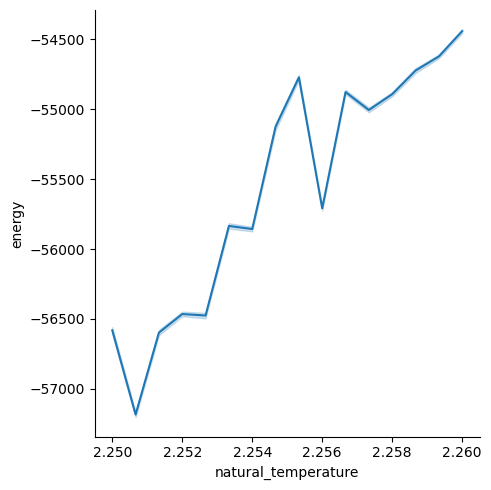

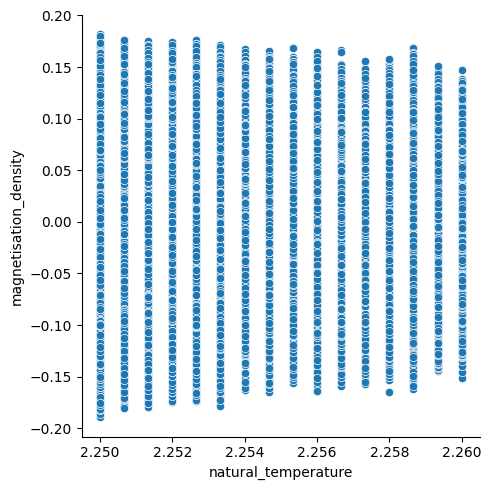

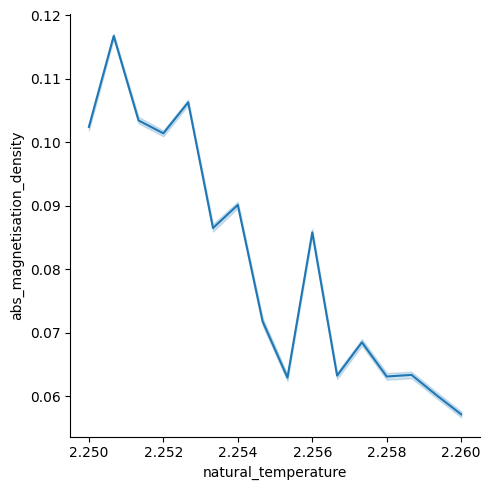

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

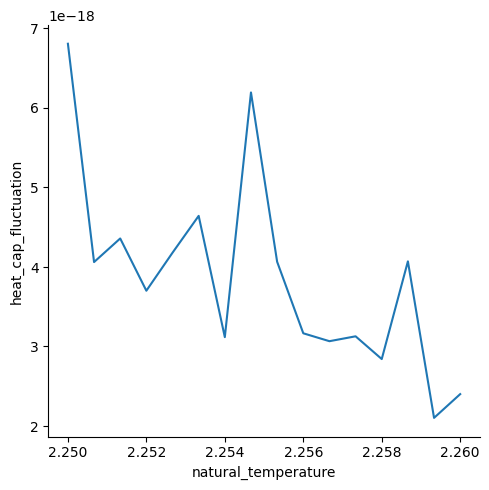

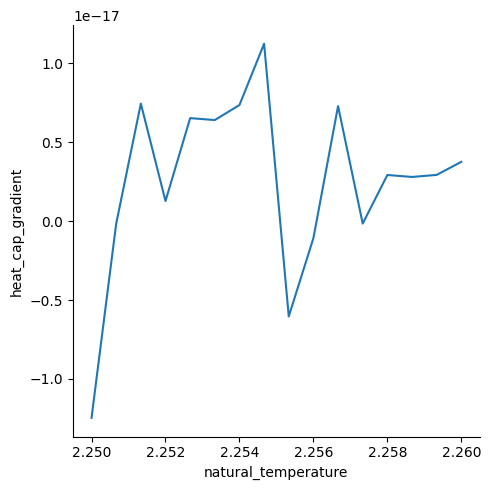

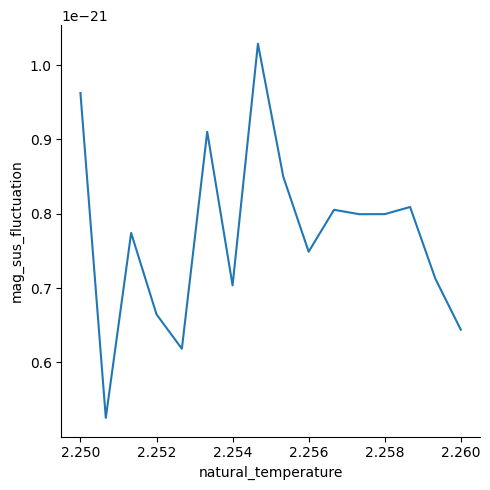

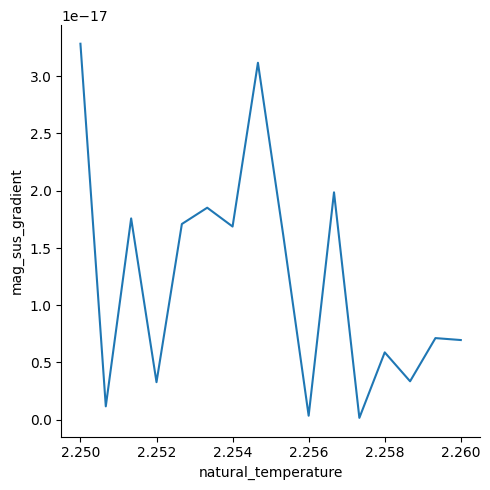

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

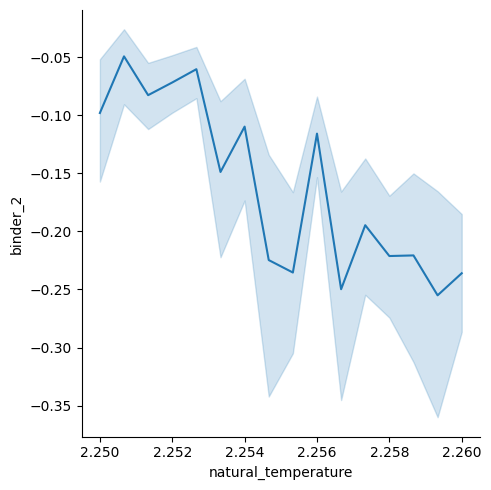

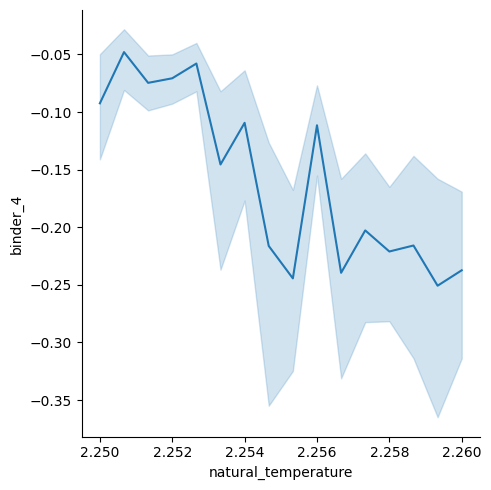

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )